### Namibian power network generated from PyPSA-Earth-Sec - an open energy system optimization model

scenario configuration options : optimistic, realistic, conservative

References : 

For more information on the model, refer to the following sources.

[pypsa-earth-sec](https://github.com/pypsa-meets-earth/pypsa-earth-sec) on GitHub.

check [documentation](https://github.com/pypsa-meets-earth/documentation) for [pypsa-earth](https://github.com/pypsa-meets-earth/pypsa-earth) relation information.

see [pypsa-meets-earth](https://github.com/pypsa-meets-earth), 2023) project on GitHub. 

In [2]:
%run -i ../functions/load_packages.ipynb
%run -i ../functions/helper_functions.ipynb

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
plt.rcParams["figure.dpi"] = 300
plt.rcParams.update({'font.size': 16}) # must set in top

### Setup network files and relevant technologies for 2030

In [3]:
res_techs = [
        "csp",
        "rooftop-solar",
        "solar",
        "onwind",
        "onwind2",
        "offwind",
        "offwind2",
        "ror",
    ]
scen_dict = {'Optimistic 2030':{
                      'run': 'MT_test_final_opt', 'cluster': '30', 'ir': '0.076', 'ds':'NZ'
                  },
              'Realistic 2030':{
                      'run': 'MT_real30', 'cluster': '30', 'ir': '0.082', 'ds':'AP'
              },
            'Conservative 2030':{
                      'run': 'MT_con30', 'cluster': '30', 'ir': '0.097', 'ds':'AP'
            },
}
pes_dir = "../../sandbox-cs/pypsa-earth-sec"
Q30 = [
        "1",
        "5",
        "50",
        "100",
        "200"
    ]
timestep = "3"

### Technology share

In [3]:

def tech_share(scen_dict,pes_dir):           
#n30 elec network
    df = pd.DataFrame()
   
    for pathway in scen_dict.keys():
        scenario = scen_dict[pathway]
        n = pypsa.Network(pes_dir +"/results/{}/postnetworks/elec_s_{}_ec_lc1.0_Co2L_{}H_2030_{}_{}_0export.nc".format(scenario["run"], scenario["cluster"], timestep, scenario["ir"], scenario["ds"]))
        df1 = pd.DataFrame()
        tech = ["solar", "onwind","offwind", "ror", "oil", "coal", "csp"]#,"gas", "biogas"]#, offwind "biomass EOP","OCGT"]
        for t in tech:
            li = []
            # if t == "biomass EOP" or t == "OCGT":
            #     tech_cap = n.links.loc[n.links.carrier == t].p_nom_opt.sum()
            #     tech_total = n.links.loc[n.links.carrier == t].p_nom_opt.sum() + n.links.loc[n.links.carrier == t].p_nom_opt.sum() + 
            tech_cap = n.generators.loc[n.generators.carrier == t].p_nom_opt.sum()
            ref_cap = n.generators.loc[n.generators.carrier == t].p_nom.sum()
            li.append((tech_cap/1e3).round(2))
            li.append(((tech_cap/n.generators.p_nom_opt.sum())*1e2).round(2))
            if ref_cap>0:
                li.append(((tech_cap-ref_cap)/1e3).round(2))
            else:
                li.append(0)
            dftemp = pd.DataFrame(li)
            dftemp.index = ['{} [GW]'.format(pathway),'{} Share [%]'.format(pathway),'{} Expansion [GW]'.format(pathway)]
            dftemp.columns=["{}".format(t)]
        #print("{} technology share: {} MW ( {} % )".format(t, tech_cap, (tech_cap/n.generators.p_nom_opt.sum())*1e2))
            df1 = pd.concat([df1, dftemp], axis=1)
        df = pd.concat([df, df1], axis=0)
#n_30.generators.groupby(["carrier"]).p_nom_opt.sum().sort_values()
    return df
df_tech = tech_share(scen_dict,pes_dir)


INFO:pypsa.io:Imported network elec_s_30_ec_lc1.0_Co2L_3H_2030_0.076_NZ_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_30_ec_lc1.0_Co2L_3H_2030_0.082_AP_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_30_ec_lc1.0_Co2L_3H_2030_0.097_AP_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores


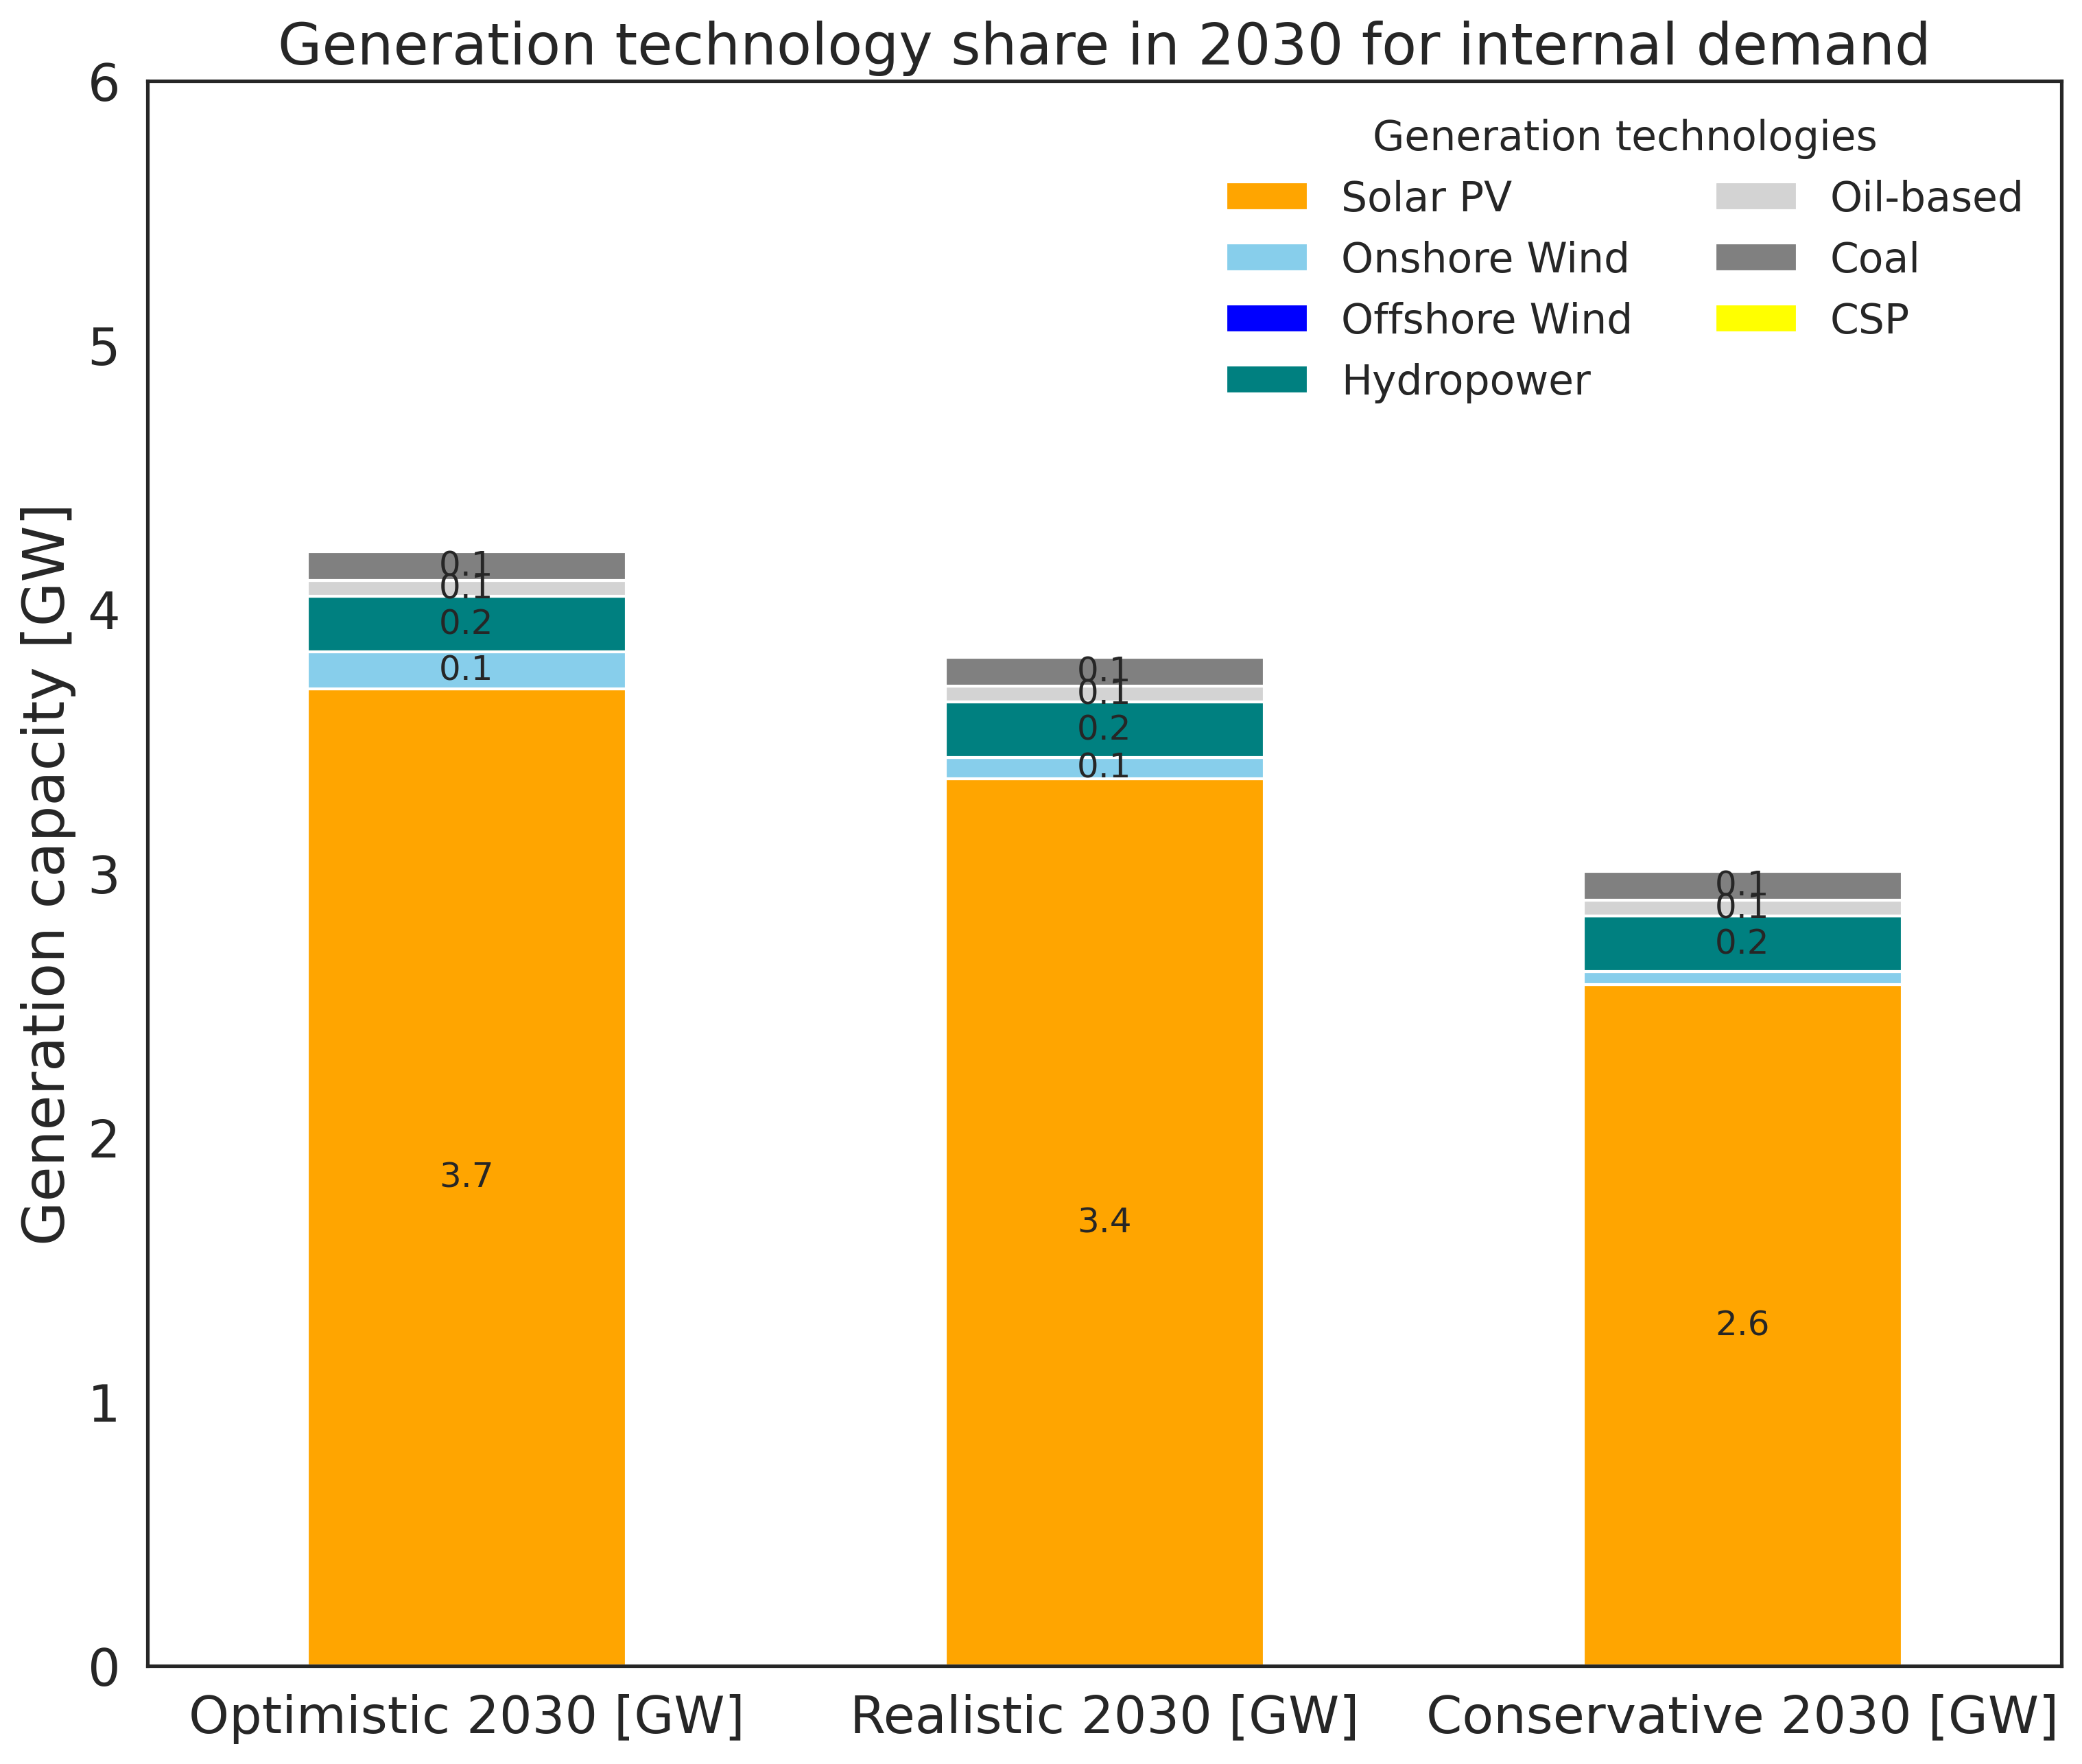

In [28]:
import seaborn as sns
sns.set_style("white")

colors = ["orange", "skyblue", "blue", "teal", "lightgray", "gray", "yellow"]
label = ['Solar PV', 'Onshore Wind', 'Offshore Wind', 'Hydropower', 'Oil-based', 'Coal', 'CSP']
sns.set_palette(sns.color_palette(colors))

keep = ["Optimistic 2030 [GW]","Realistic 2030 [GW]","Conservative 2030 [GW]"]
tech_plot = df_tech[df_tech.index.isin(keep)]
#tech_plot.drop(["Optimistic 2030 Share[%]","Realistic 2030 Share[%]","Conservative 2030 Share[%]"], inplace=True)
ax = tech_plot.plot(kind= "bar",stacked=True, figsize=(12,10),rot=0, ylim=(0, 6),fontsize=18, title="Generation technology share in 2030 for internal demand", ylabel="Generation capacity [GW]")
ax.title.set_size(20)
ax.yaxis.get_label().set_fontsize(20)
for c in ax.containers:

    # Optional: if the segment is small or 0, customize the labels
    labels = [v.get_height().round(1) if v.get_height().round(1) > 0 else '' for v in c]
    
    # remove the labels parameter if it's not needed for customized labels
    ax.bar_label(c, labels=labels, label_type='center')
plt.legend(
    labels=label,
    loc='upper right',ncol=2,
    fontsize='large',
    title='Generation technologies',
    title_fontsize='large', frameon= False)
plt.show()


In [5]:
def link_share(scen_dict,pes_dir):           
#n30 elec network
    df = pd.DataFrame()
   
    for pathway in scen_dict.keys():
        scenario = scen_dict[pathway]
        n = pypsa.Network(pes_dir +"/results/{}/postnetworks/elec_s_{}_ec_lc1.0_Co2L_{}H_2030_{}_{}_0export.nc".format(scenario["run"], scenario["cluster"], timestep, scenario["ir"], scenario["ds"]))
        df1 = pd.DataFrame()
        tech = ["biomass EOP","OCGT"]
        for t in tech:
            li = []
            tech_cap = n.links.loc[n.links.carrier == t].p_nom_opt.sum()
            li.append((tech_cap/1e3).round(2))
            li.append(((tech_cap/n.links.p_nom_opt.sum())*1e2).round(2))
            ref_cap = n.links.loc[n.links.carrier == t].p_nom.sum()
            print(ref_cap)
            if ref_cap>=0:
                li.append(((tech_cap-ref_cap)/1e3).round(2))
            else:
                li.append(0)
            dftemp = pd.DataFrame(li)
            dftemp.index = ['{} Capacity [GW]'.format(pathway),'{} Share [%]'.format(pathway),'{} Expansion [GW]'.format(pathway)]
            dftemp.columns=["{}".format(t)]
        #print("{} technology share: {} MW ( {} % )".format(t, tech_cap, (tech_cap/n.generators.p_nom_opt.sum())*1e2))
            df1 = pd.concat([df1, dftemp], axis=1)
        df = pd.concat([df, df1], axis=0)
#n_30.generators.groupby(["carrier"]).p_nom_opt.sum().sort_values()
    return df
pd.concat([tech_share(scen_dict,pes_dir), link_share(scen_dict,pes_dir)], axis=1) 

INFO:pypsa.io:Imported network elec_s_30_ec_lc1.0_Co2L_3H_2030_0.076_NZ_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_30_ec_lc1.0_Co2L_3H_2030_0.082_AP_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_30_ec_lc1.0_Co2L_3H_2030_0.097_AP_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_30_ec_lc1.0_Co2L_3H_2030_0.076_NZ_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores


0.0
0.0


INFO:pypsa.io:Imported network elec_s_30_ec_lc1.0_Co2L_3H_2030_0.082_AP_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores


0.0
0.0


INFO:pypsa.io:Imported network elec_s_30_ec_lc1.0_Co2L_3H_2030_0.097_AP_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores


0.0
0.0


,solar,onwind,offwind,ror,oil,coal,csp,biomass EOP,OCGT
Optimistic 2030 [GW],3.70,0.14,0.0,0.21,0.06,0.11,0.0,NaN,NaN
Optimistic 2030 Share [%],64.97,2.42,0.0,3.75,1.02,1.94,0.0,0.0,0.05
Optimistic 2030 Expansion [GW],3.56,0.13,0.0,0.00,0.00,0.00,0.0,0.0,0.00
Realistic 2030 [GW],3.36,0.08,0.0,0.21,0.06,0.11,0.0,NaN,NaN
Realistic 2030 Share [%],71.25,1.69,0.0,4.53,1.23,2.34,0.0,0.0,0.02
Realistic 2030 Expansion [GW],3.22,0.08,0.0,0.00,0.00,0.00,0.0,0.0,0.00
Conservative 2030 [GW],2.58,0.05,0.0,0.21,0.06,0.11,0.0,NaN,NaN
Conservative 2030 Share [%],74.94,1.36,0.0,6.22,1.69,3.22,0.0,0.0,9.61
Conservative 2030 Expansion [GW],2.43,0.04,0.0,0.00,0.00,0.00,0.0,0.0,0.33
Optimistic 2030 Capacity [GW],NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.00


### Additional renewable and electrolyser capacity needed for export quantities

In [6]:
def calc_additional_res(n, n_ref, tech):
    res_index = n.generators.filter(regex='{}$'.format(tech), axis=0).index

    res_cap = n.generators.p_nom_opt[res_index].sum()
    res_cap_ref = n_ref.generators.p_nom_opt[res_index].sum()

    return (res_cap - res_cap_ref) / 1e3

def calc_additional_elec(n, n_ref):

    elec_cap = n.links.filter(like='Electrolysis', axis=0).p_nom_opt.sum()
    res_cap_ref = n_ref.links.filter(like='Electrolysis', axis=0).p_nom_opt.sum()

    return (elec_cap - res_cap_ref) / 1e3

In [7]:
def add_tech_gw(Q30, res_techs, scen_dict, pes_dir):
    df = pd.DataFrame()
    for q in Q30:
        for pathway in scen_dict.keys():
            li = []
            scenario = scen_dict[pathway]
            n_ref = pypsa.Network(pes_dir + "/results/{}/postnetworks/elec_s_{}_ec_lc1.0_Co2L_{}H_2030_{}_{}_0export.nc".format(scenario["run"], scenario["cluster"], timestep, scenario["ir"], scenario["ds"]))
            n = pypsa.Network(pes_dir +"/results/{}/postnetworks/elec_s_{}_ec_lc1.0_Co2L_{}H_2030_{}_{}_{}export.nc".format(scenario["run"], scenario["cluster"], timestep, scenario["ir"], scenario["ds"], q))
            
            #Additional renewable for export quantities
            for tech in res_techs:
                li.append(calc_additional_res(n, n_ref, tech))
            
            #Additional electrolyzer for export quantities
            li.append(calc_additional_elec(n, n_ref))

            dftemp = pd.DataFrame(li)
            dftemp.index = ['Additional CSP [GW]','Additional Rooftop Solar [GW]','Additional Solar [GW]','Additional Onshore wind [GW]','Additional Onshore wind-2 [GW]','Additional Offshore Wind [GW]','Additional Offshore Wind-2 [GW]','Additional Hydro[GW]','Additional Electrolyser[GW]]']
            dftemp.columns=["{} [{} TWh]".format(pathway, q)]
            df = pd.concat([df, dftemp], axis=1)  
    return df
add_tech_gw(Q30, res_techs, scen_dict,pes_dir)

INFO:pypsa.io:Imported network elec_s_30_ec_lc1.0_Co2L_3H_2030_0.076_NZ_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_30_ec_lc1.0_Co2L_3H_2030_0.076_NZ_1export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_30_ec_lc1.0_Co2L_3H_2030_0.082_AP_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_30_ec_lc1.0_Co2L_3H_2030_0.082_AP_1export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_30_ec_lc1.0_Co2L_3H_2030_0.097_AP_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_30_ec_lc1.0_Co2L_3H_2030_0.097_AP_1export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Im

,Optimistic 2030 [1 TWh],Realistic 2030 [1 TWh],Conservative 2030 [1 TWh],Optimistic 2030 [5 TWh],Realistic 2030 [5 TWh],Conservative 2030 [5 TWh],Optimistic 2030 [50 TWh],Realistic 2030 [50 TWh],Conservative 2030 [50 TWh],Optimistic 2030 [100 TWh],Realistic 2030 [100 TWh],Conservative 2030 [100 TWh],Optimistic 2030 [200 TWh],Realistic 2030 [200 TWh],Conservative 2030 [200 TWh]
Additional CSP [GW],0.000204,0.000052,0.000130,0.000392,0.000211,3.025015e-05,0.000396,0.000022,0.000365,0.000288,1.906255e-05,0.000213,1.350838e-05,0.000022,0.000135
Additional Rooftop Solar [GW],0.000220,0.000072,0.000132,0.000377,0.000236,-8.287582e-08,0.000260,-0.000003,0.000251,0.000139,-9.826862e-06,0.000110,-9.707141e-06,-0.000005,0.000073
Additional Solar [GW],0.995512,0.873758,0.913011,4.533275,4.339802,4.366063e+00,44.746039,43.607953,43.641094,89.040266,8.725291e+01,87.448979,1.767628e+02,174.483988,175.253714
Additional Onshore wind [GW],-0.129693,-0.071885,-0.041712,-0.131782,-0.074180,-4.206537e-02,-0.132029,-0.074965,-0.041329,-0.132399,-7.498548e-02,-0.041685,-1.329662e-01,-0.074979,-0.041798
Additional Onshore wind-2 [GW],0.000627,0.000149,0.000330,0.001118,0.000655,8.108678e-05,0.001041,0.000049,0.000916,0.000828,3.990617e-05,0.000546,9.085020e-06,0.000036,0.000374
Additional Offshore Wind [GW],0.000107,0.000016,0.000067,0.000209,0.000121,1.360228e-05,0.000175,0.000005,0.000186,0.000135,2.230363e-06,0.000097,7.647423e-07,0.000003,0.000065
Additional Offshore Wind-2 [GW],0.000081,0.000014,0.000052,0.000156,0.000090,8.247745e-06,0.000142,0.000003,0.000136,0.000097,1.864861e-07,0.000070,-7.160286e-07,0.000002,0.000048
Additional Hydro[GW],0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000
Additional Electrolyser[GW]],0.568306,0.576562,0.562366,2.645664,2.649679,2.524221e+00,25.692737,25.886115,25.614612,51.268782,5.169948e+01,51.163413,1.027250e+02,103.395368,102.268571


INFO:pypsa.io:Imported network elec_s_30_ec_lc1.0_Co2L_3H_2030_0.076_NZ_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_30_ec_lc1.0_Co2L_3H_2030_0.076_NZ_1export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_30_ec_lc1.0_Co2L_3H_2030_0.076_NZ_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_30_ec_lc1.0_Co2L_3H_2030_0.076_NZ_5export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_30_ec_lc1.0_Co2L_3H_2030_0.076_NZ_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_30_ec_lc1.0_Co2L_3H_2030_0.076_NZ_50export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:I

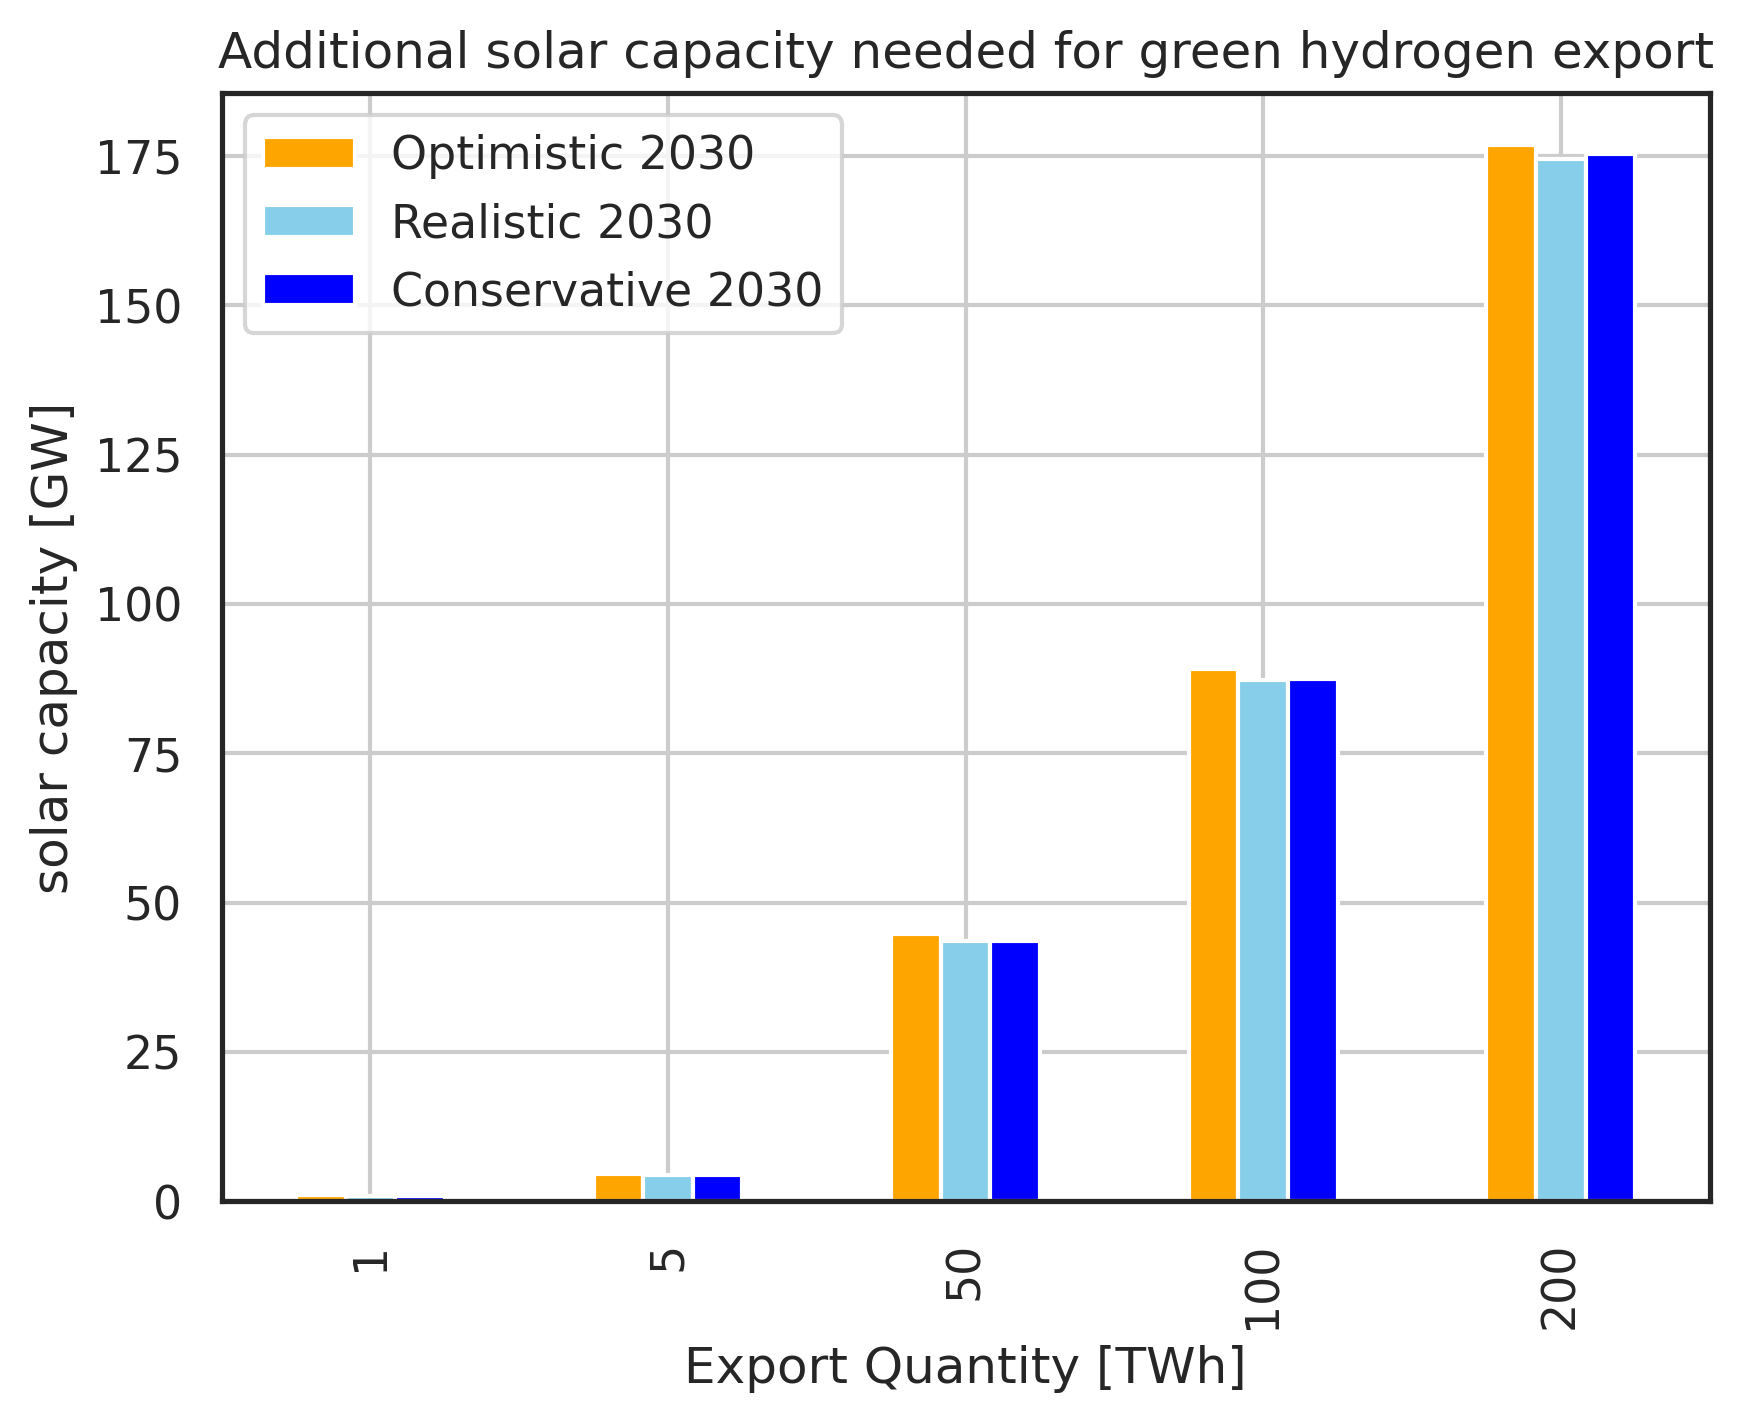

In [8]:
def  plot_res_cap(Q30, res_tech, scen_dict, pes_dir):   
    for tech in res_tech:
        df = pd.DataFrame()
        for pathway in scen_dict.keys():
            li = []
            qi = []
            for q in Q30:
                qi.append(q)
                scenario = scen_dict[pathway]
                n_ref = pypsa.Network(pes_dir + "/results/{}/postnetworks/elec_s_{}_ec_lc1.0_Co2L_{}H_2030_{}_{}_0export.nc".format(scenario["run"], scenario["cluster"], timestep, scenario["ir"], scenario["ds"]))
                n = pypsa.Network(pes_dir + "/results/{}/postnetworks/elec_s_{}_ec_lc1.0_Co2L_{}H_2030_{}_{}_{}export.nc".format(scenario["run"], scenario["cluster"], timestep, scenario["ir"], scenario["ds"], q))
                
                #Additional renewable for export quantities
                li.append(calc_additional_res(n, n_ref, tech))
                
            dftemp = pd.DataFrame([li])
            dftemp.index = [pathway]
            dftemp.columns=qi
            df = pd.concat([df, dftemp])
        df=df.T
        df.plot(kind="bar", legend=True,grid=True,xlabel="Export Quantity [TWh]", ylabel="{} capacity [GW]".format(tech), title = "Additional {} capacity needed for green hydrogen export".format(tech) )
      
res_tech = [
        "solar"
    ]
plot_res_cap(Q30, res_tech, scen_dict,pes_dir)

### Additional electrolyzer capacity

INFO:pypsa.io:Imported network elec_s_30_ec_lc1.0_Co2L_3H_2030_0.076_NZ_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_30_ec_lc1.0_Co2L_3H_2030_0.076_NZ_1export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_30_ec_lc1.0_Co2L_3H_2030_0.076_NZ_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_30_ec_lc1.0_Co2L_3H_2030_0.076_NZ_5export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_30_ec_lc1.0_Co2L_3H_2030_0.076_NZ_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_30_ec_lc1.0_Co2L_3H_2030_0.076_NZ_50export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:I

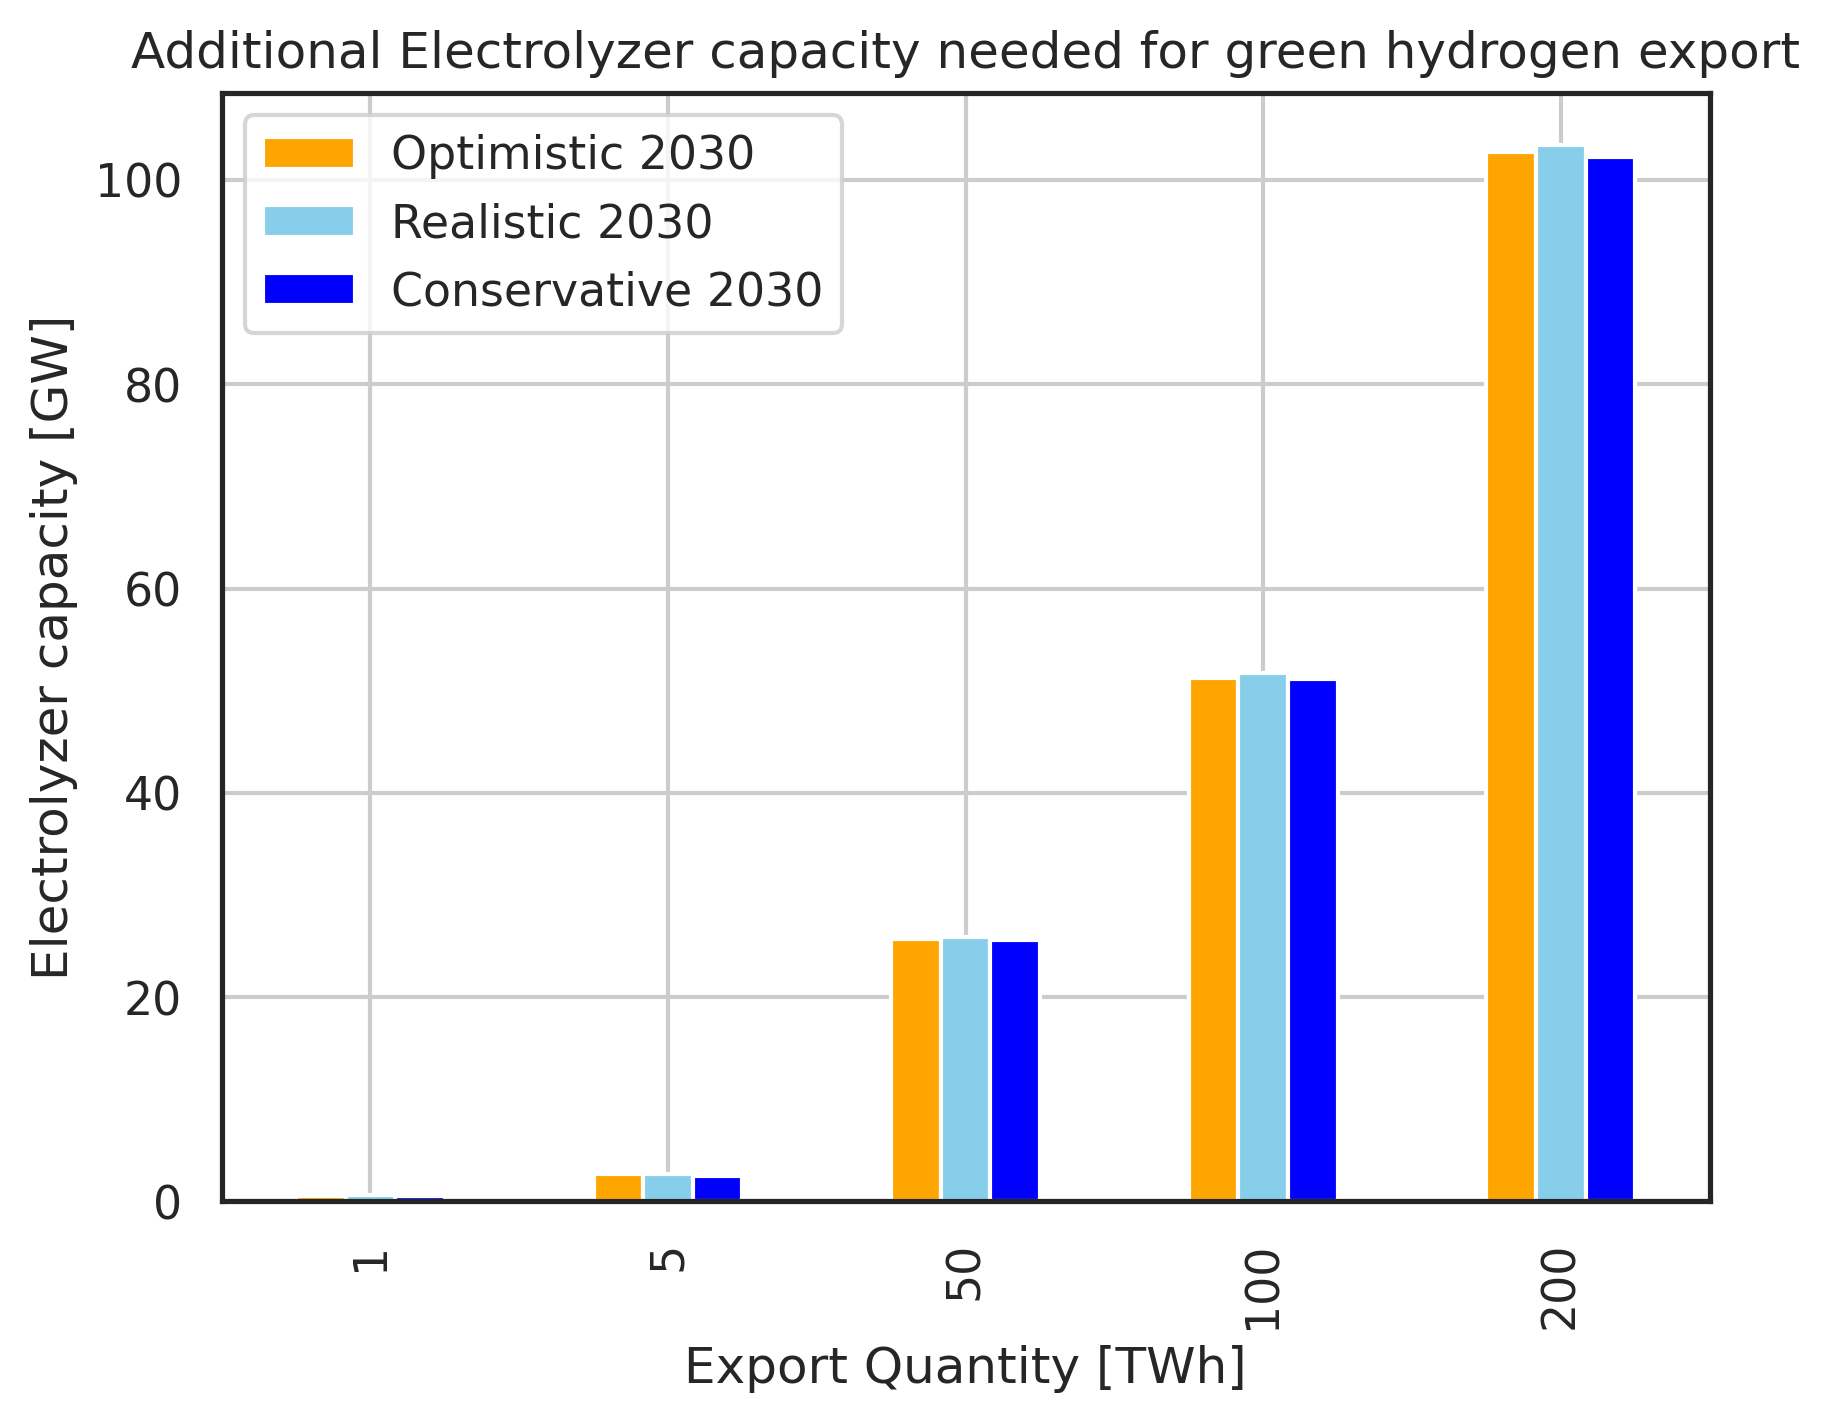

In [9]:
def plot_elzr_cap(Q30,scen_dict,pes_dir):
    df = pd.DataFrame()
    for pathway in scen_dict.keys():
        li = []
        qi = []
        for q in Q30:
            qi.append(q)
            scenario = scen_dict[pathway]
            n_ref = pypsa.Network(pes_dir+"/results/{}/postnetworks/elec_s_{}_ec_lc1.0_Co2L_{}H_2030_{}_{}_0export.nc".format(scenario["run"], scenario["cluster"], timestep, scenario["ir"], scenario["ds"]))
            n = pypsa.Network(pes_dir+"/results/{}/postnetworks/elec_s_{}_ec_lc1.0_Co2L_{}H_2030_{}_{}_{}export.nc".format(scenario["run"], scenario["cluster"], timestep, scenario["ir"], scenario["ds"], q))
            
            #Additional renewable for export quantities
            li.append(calc_additional_elec(n, n_ref))

        dftemp = pd.DataFrame([li])
        dftemp.index = [pathway]
        dftemp.columns=qi
        df = pd.concat([df, dftemp])
    df=df.T
    df.plot(kind="bar", legend=True, grid=True, xlabel="Export Quantity [TWh]", ylabel="Electrolyzer capacity [GW]", 
    title = "Additional Electrolyzer capacity needed for green hydrogen export")

plot_elzr_cap(Q30,scen_dict,pes_dir)
#df

### Utilization of renewable technologies and electrolysezer capacities for export quantities and locations.

In [10]:
def calc_util(n, tech):
    
    tech_index = n.generators.loc[n.generators.carrier == tech].index

    weightings = pd.DataFrame(
        np.outer(n.snapshot_weightings["generators"], [1.0] * len(tech_index)),
        index=n.snapshots,
        columns=tech_index,
    )
    gen_tech = (n.generators_t.p.filter(regex='{}$'.format(tech)) * weightings).sum()
    installed_cap = n.generators.p_nom_opt.filter(regex='{}$'.format(tech))
    year_avail = (n.generators_t.p_max_pu.filter(regex='{}$'.format(tech)) * weightings ).sum()
    
    max_gen_solar=(installed_cap * year_avail)
    
    return (gen_tech/max_gen_solar).mean()  

def calc_elec_capa(n):

    elec_cap = n.links.filter(like='Electrolysis', axis=0).p_nom_opt.sum() *8760
    elec_output = n.links_t.p0.filter(like='Electrolysis').sum().sum() * float(timestep)

    return elec_output / elec_cap
    
def calc_elec_capa_exp(n):

    export_buses = n.links.loc[n.links.bus1 == 'H2 export bus', 'bus0'] + ' Electrolysis'

    elec_cap = n.links.loc[export_buses].p_nom_opt.sum()
    elec_output = n.links_t.p0[export_buses].sum().sum() *  float(timestep)

    return elec_output / (elec_cap * 8760)

In [11]:
def calc_util(n, tech):
    
    tech_index = n.generators.loc[n.generators.carrier == tech].index

    weightings = pd.DataFrame(
        np.outer(n.snapshot_weightings["generators"], [1.0] * len(tech_index)),
        index=n.snapshots,
        columns=tech_index,
    )
    gen_tech = (n.generators_t.p.filter(regex='{}$'.format(tech)) * weightings).sum()
    installed_cap = n.generators.p_nom_opt.filter(regex='{}$'.format(tech))
    year_avail = (n.generators_t.p_max_pu.filter(regex='{}$'.format(tech)) * weightings ).sum()
    
    max_gen_solar=(installed_cap * year_avail)
    
    return (gen_tech/max_gen_solar).mean()  

In [12]:
def calc_flh(n, tech):
    
    tech_index = n.generators.loc[n.generators.carrier == tech].index

    weightings = pd.DataFrame(
        np.outer(n.snapshot_weightings["generators"], [1.0] * len(tech_index)),
        index=n.snapshots,
        columns=tech_index,
    )
    year_avail = (n.generators_t.p_max_pu.filter(regex=' {}$'.format(tech)) * weightings ).sum()
    #year_avail = pd.DataFrame(year_avail)
    return year_avail.mean()
    #return year_avail.mean()
n=pypsa.Network("/home/raj08555/dev/sandbox-cs/pypsa-earth-sec/results/MT_opt30/postnetworks/elec_s_30_ec_lc1.0_Co2L_3H_2030_0.076_NZ_200export.nc")
calc_flh(n, "solar")
# n.buses.carrier.unique()
# def calc_elec_capa(n):

#     elec_cap = n.links.filter(like='Electrolysis', axis=0).p_nom_opt.sum() *8760
#     elec_output = n.links_t.p0.filter(like='Electrolysis').sum().sum() * float(timestep)

#     return elec_output / elec_cap
    
# def calc_elec_capa_exp(n):

#     export_buses = n.links.loc[n.links.bus1 == 'H2 export bus', 'bus0'] + ' Electrolysis'

#     elec_cap = n.links.loc[export_buses].p_nom_opt.sum() *8760
#     elec_output = n.links_t.p0[export_buses].sum().sum() *  float(timestep)

#     return elec_output / elec_cap

INFO:pypsa.io:Imported network elec_s_30_ec_lc1.0_Co2L_3H_2030_0.076_NZ_200export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores


1672.003955644923

In [13]:
# n=pypsa.Network("/home/raj08555/dev/sandbox-cs/pypsa-earth-sec/results/MT_real30/postnetworks/elec_s_30_ec_lc1.0_Co2L_3H_2030_0.082_AP_100export.nc")

# calc_flh(n, "solar")

In [14]:
def util_res_percent(Q30, res_techs, scen_dict,pes_dir):
    df = pd.DataFrame()
    for q in Q30:
        for pathway in scen_dict.keys():
            li = []
            scenario = scen_dict[pathway]
            n_ref = pypsa.Network(pes_dir + "/results/{}/postnetworks/elec_s_{}_ec_lc1.0_Co2L_{}H_2030_{}_{}_0export.nc".format(scenario["run"], scenario["cluster"], timestep, scenario["ir"], scenario["ds"]))
            n = pypsa.Network(pes_dir+"/results/{}/postnetworks/elec_s_{}_ec_lc1.0_Co2L_{}H_2030_{}_{}_{}export.nc".format(scenario["run"], scenario["cluster"], timestep, scenario["ir"], scenario["ds"], q))
            
            #Additional renewable for export quantities
            for tech in res_techs:
                li.append(calc_util(n, tech)*1e2)
            
            #Additional electrolyzer for export quantities
            li.append(calc_elec_capa(n)*1e2)
            li.append(calc_elec_capa_exp(n)*1e2)
            dftemp = pd.DataFrame(li)
            dftemp.index = ['CSP Utilisation [%]','Rooftop-solar Utilisation [%]','Solar Utilisation [%]','Onshore wind Utilisation [%]','Onshore wind-2 Utilisation [%]','Offshore wind Utilisation [%]','Onshore wind-2 Utilisation [%]','Hydro Utilisation [%]','Electrolyser Utilisation [%]','Electrolyser Utilisation at export node [%]']
            dftemp.columns=["{} [{} TWh]".format(pathway,q)]
            df = pd.concat([df, dftemp], axis=1)
            #df.columns=["{} [{} TWh]".format(pathway, q)]   
    return df

util_res_percent(Q30, res_techs, scen_dict,pes_dir)

INFO:pypsa.io:Imported network elec_s_30_ec_lc1.0_Co2L_3H_2030_0.076_NZ_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_30_ec_lc1.0_Co2L_3H_2030_0.076_NZ_1export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_30_ec_lc1.0_Co2L_3H_2030_0.082_AP_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_30_ec_lc1.0_Co2L_3H_2030_0.082_AP_1export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_30_ec_lc1.0_Co2L_3H_2030_0.097_AP_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_30_ec_lc1.0_Co2L_3H_2030_0.097_AP_1export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Im

,Optimistic 2030 [1 TWh],Realistic 2030 [1 TWh],Conservative 2030 [1 TWh],Optimistic 2030 [5 TWh],Realistic 2030 [5 TWh],Conservative 2030 [5 TWh],Optimistic 2030 [50 TWh],Realistic 2030 [50 TWh],Conservative 2030 [50 TWh],Optimistic 2030 [100 TWh],Realistic 2030 [100 TWh],Conservative 2030 [100 TWh],Optimistic 2030 [200 TWh],Realistic 2030 [200 TWh],Conservative 2030 [200 TWh]
CSP Utilisation [%],58.517132,64.296988,68.650314,60.159044,67.619685,62.154170,59.410230,61.005908,62.951790,59.906046,61.315375,63.385816,59.528403,61.406534,62.822334
Rooftop-solar Utilisation [%],55.541804,59.694760,59.667835,58.093057,60.336068,52.915069,54.108212,57.829815,54.706067,49.163413,56.152156,54.301470,52.755810,56.334261,55.694021
Solar Utilisation [%],79.388999,78.838946,85.241255,81.074481,78.298210,79.356038,74.703536,76.563786,74.691519,76.884762,72.305505,72.708972,78.386788,73.085495,73.561582
Onshore wind Utilisation [%],78.949500,82.503142,82.678731,78.526445,82.587490,82.160623,74.652267,81.537626,78.347357,75.888944,81.278282,79.271325,79.131617,81.070749,80.440633
Onshore wind-2 Utilisation [%],64.509365,68.868976,67.474076,65.099592,70.011871,67.324554,62.285884,68.043648,64.801243,65.816644,68.516844,66.031339,62.735328,66.739866,67.548825
Offshore wind Utilisation [%],57.253958,59.219212,61.270012,61.603599,63.624374,63.109519,56.934177,63.781971,62.791069,60.172129,60.740294,62.296718,56.179607,61.328330,63.385362
Onshore wind-2 Utilisation [%],53.286814,55.360821,57.712571,56.233173,59.030406,57.059288,55.368536,58.677566,57.091238,54.990769,56.266568,57.087094,52.238475,56.419408,58.634439
Hydro Utilisation [%],inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
Electrolyser Utilisation [%],33.811188,33.707095,34.917212,32.910396,32.872486,34.468286,32.795347,32.553972,32.925825,32.806086,32.535769,32.889704,32.715286,32.504894,32.869326
Electrolyser Utilisation at export node [%],41.640882,27.179825,31.779404,38.767997,32.748318,34.770252,28.108708,32.532644,32.861925,28.600302,32.518182,32.838818,31.153487,32.493558,32.839498


### Scenario based full-load-hours (flh) utilization (%)


INFO:pypsa.io:Imported network elec_s_30_ec_lc1.0_Co2L_3H_2030_0.076_NZ_1export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_30_ec_lc1.0_Co2L_3H_2030_0.076_NZ_5export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_30_ec_lc1.0_Co2L_3H_2030_0.076_NZ_50export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_30_ec_lc1.0_Co2L_3H_2030_0.076_NZ_100export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_30_ec_lc1.0_Co2L_3H_2030_0.076_NZ_200export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_30_ec_lc1.0_Co2L_3H_2030_0.082_AP_1export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.

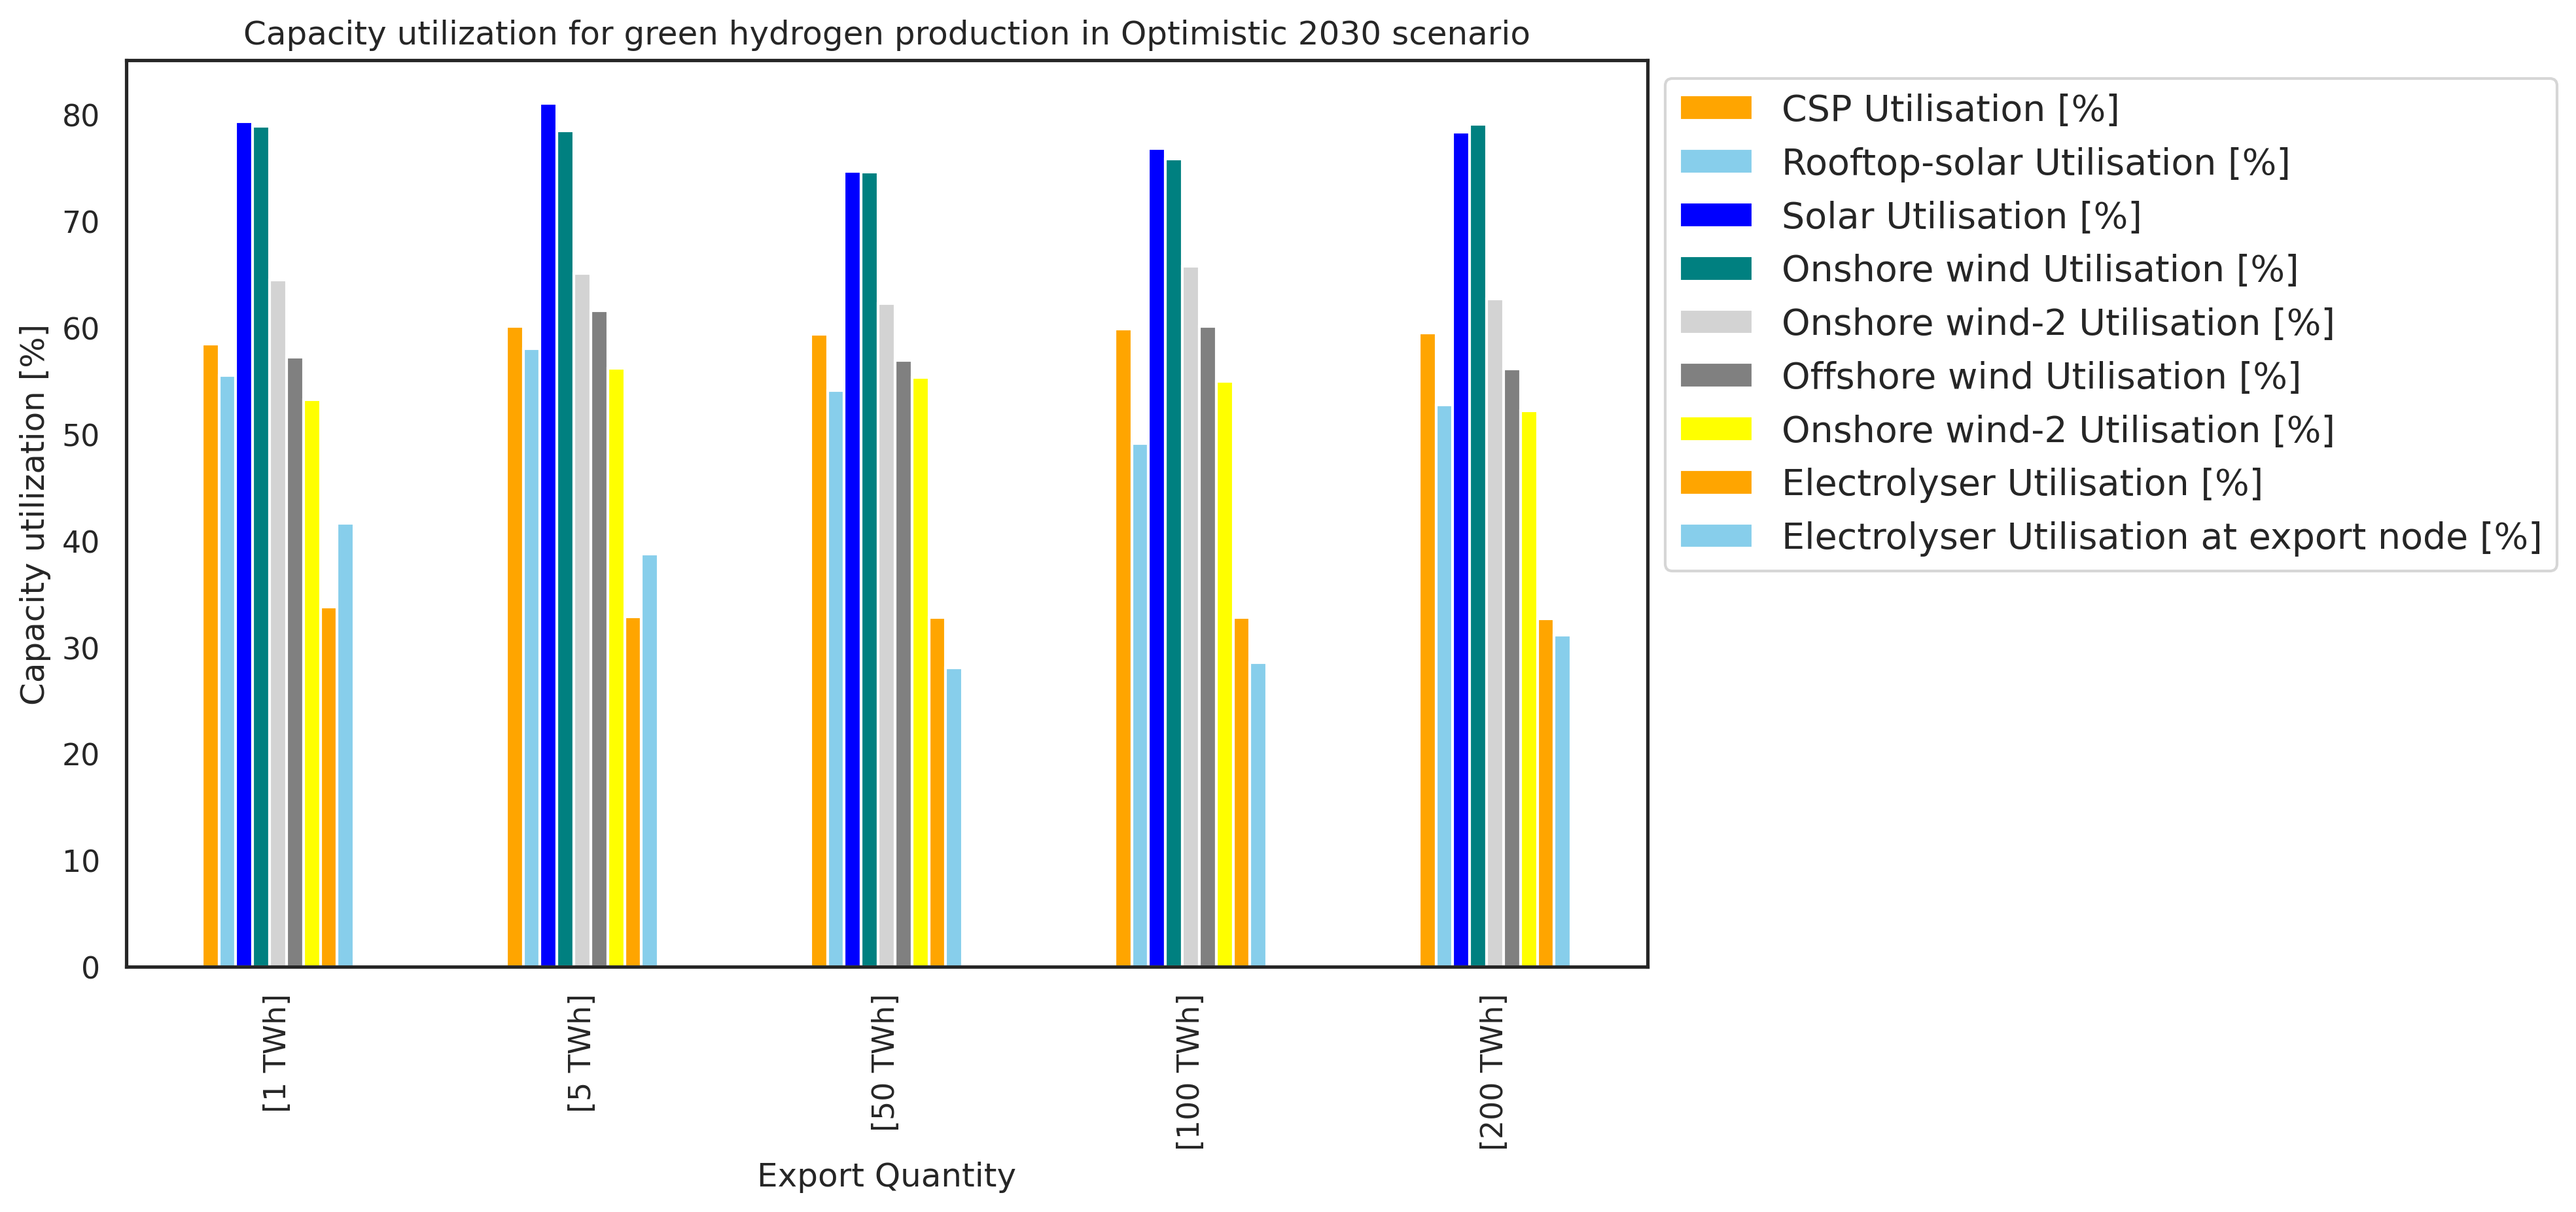

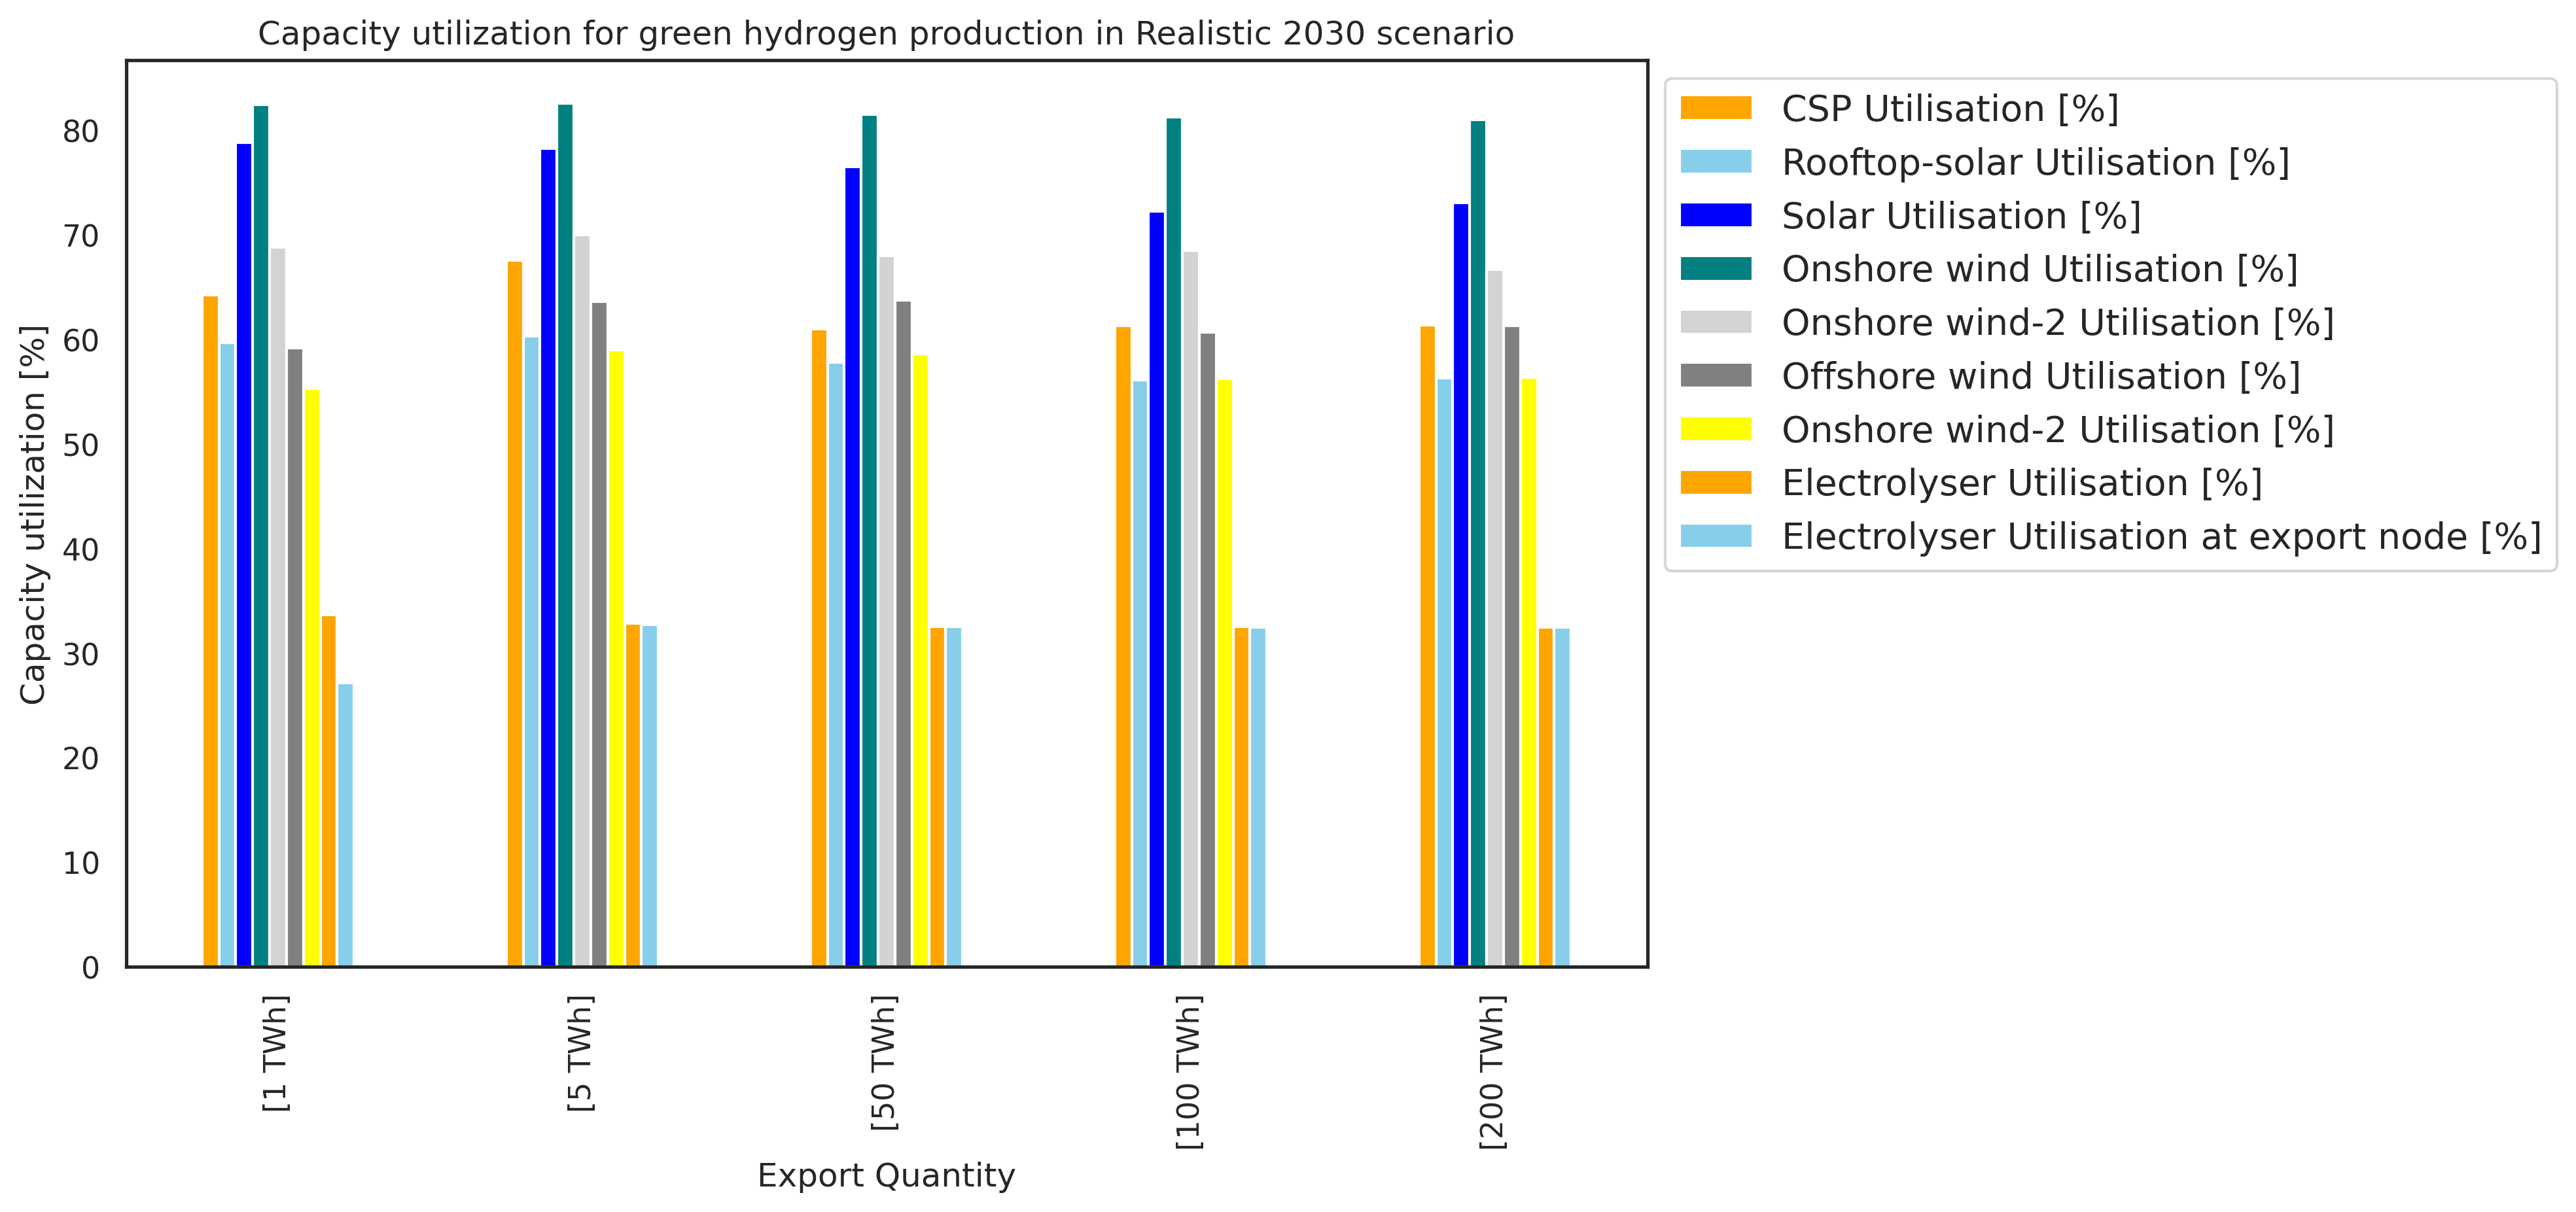

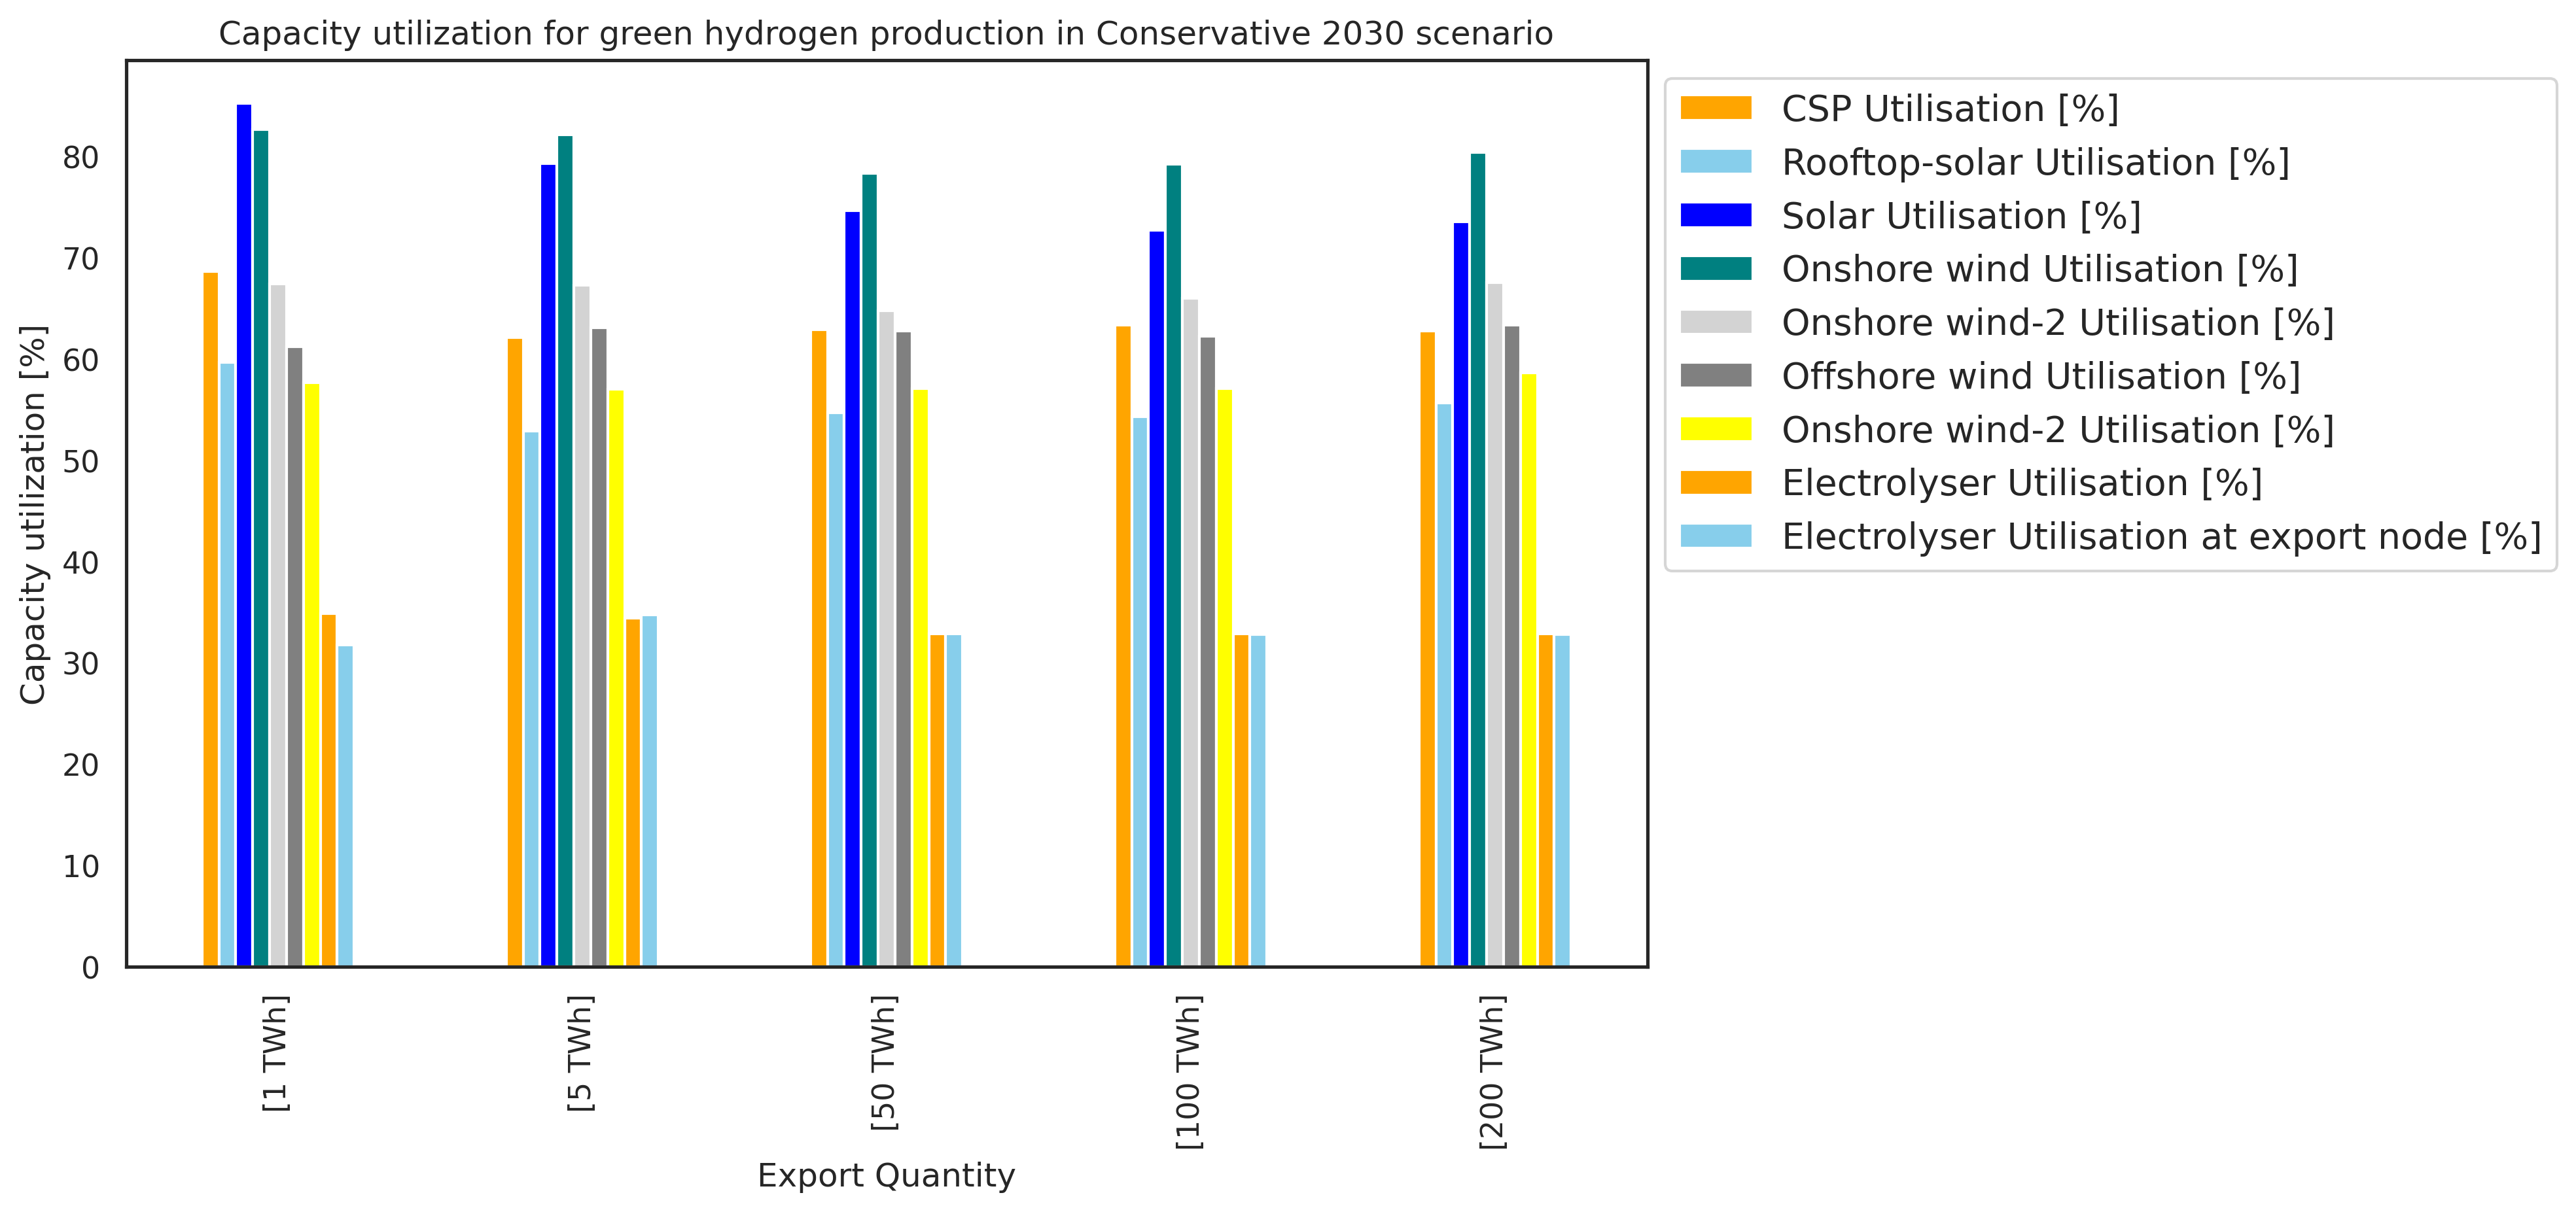

In [15]:
def plot_res_util(Q30, res_techs, scen_dict,pes_dir):
    for pathway in scen_dict.keys():
        df = pd.DataFrame()
        for q in Q30:
            li = []
            scenario = scen_dict[pathway]
            n = pypsa.Network(pes_dir + "/results/{}/postnetworks/elec_s_{}_ec_lc1.0_Co2L_{}H_2030_{}_{}_{}export.nc".format(scenario["run"], scenario["cluster"], timestep, scenario["ir"], scenario["ds"], q))
            
            #Additional renewable for export quantities
            for tech in res_techs:
                li.append(calc_util(n, tech)*1e2)
            
            #Additional electrolyzer for export quantities
            li.append(calc_elec_capa(n)*1e2)
            li.append(calc_elec_capa_exp(n)*1e2)
            dftemp = pd.DataFrame(li)
            dftemp.index = ['CSP Utilisation [%]','Rooftop-solar Utilisation [%]','Solar Utilisation [%]','Onshore wind Utilisation [%]','Onshore wind-2 Utilisation [%]','Offshore wind Utilisation [%]','Onshore wind-2 Utilisation [%]','Hydro Utilisation [%]','Electrolyser Utilisation [%]','Electrolyser Utilisation at export node [%]']
            dftemp.columns=["[{} TWh]".format(q)]
            df = pd.concat([df, dftemp], axis=1) 
        
        dfplot = df.copy()
        dfplot=dfplot.drop("Hydro Utilisation [%]")
        #ax = plt.gca()
        dfplot.T.plot(kind="bar",legend=True, xlabel="Export Quantity", ylabel="Capacity utilization [%]", 
            title = "Capacity utilization for green hydrogen production in {} scenario".format(pathway), figsize = (10,6)).legend(
        bbox_to_anchor=(1.0, 1.0),
        fontsize='small',
    )
plot_res_util(Q30, res_techs, scen_dict,pes_dir)

[20.662100456621005, 33.811188020615404, 41.64088232864658]
[20.662100456621005, 32.91039585702466, 38.76799652908491]
[20.662100456621005, 32.795346740141525, 28.108708303450157]
[20.662100456621005, 32.80608627832383, 28.600301716571337]
[20.662100456621005, 32.71528632204493, 31.15348725707684]
[20.662100456621005, 33.707094527494974, 27.1798246130539]
[20.662100456621005, 32.87248623234454, 32.74831827878467]
[20.662100456621005, 32.553972318772736, 32.53264402676173]
[20.662100456621005, 32.53576945121535, 32.518182091525304]
[20.662100456621005, 32.504894054555656, 32.49355800200161]
[20.662100456621005, 34.91721229832208, 31.779404310005066]
[20.662100456621005, 34.468285627788745, 34.77025176890822]
[20.662100456621005, 32.925824831811774, 32.861924959607315]
[20.662100456621005, 32.889703800020655, 32.8388177912235]
[20.662100456621005, 32.869325672273305, 32.839497824691406]


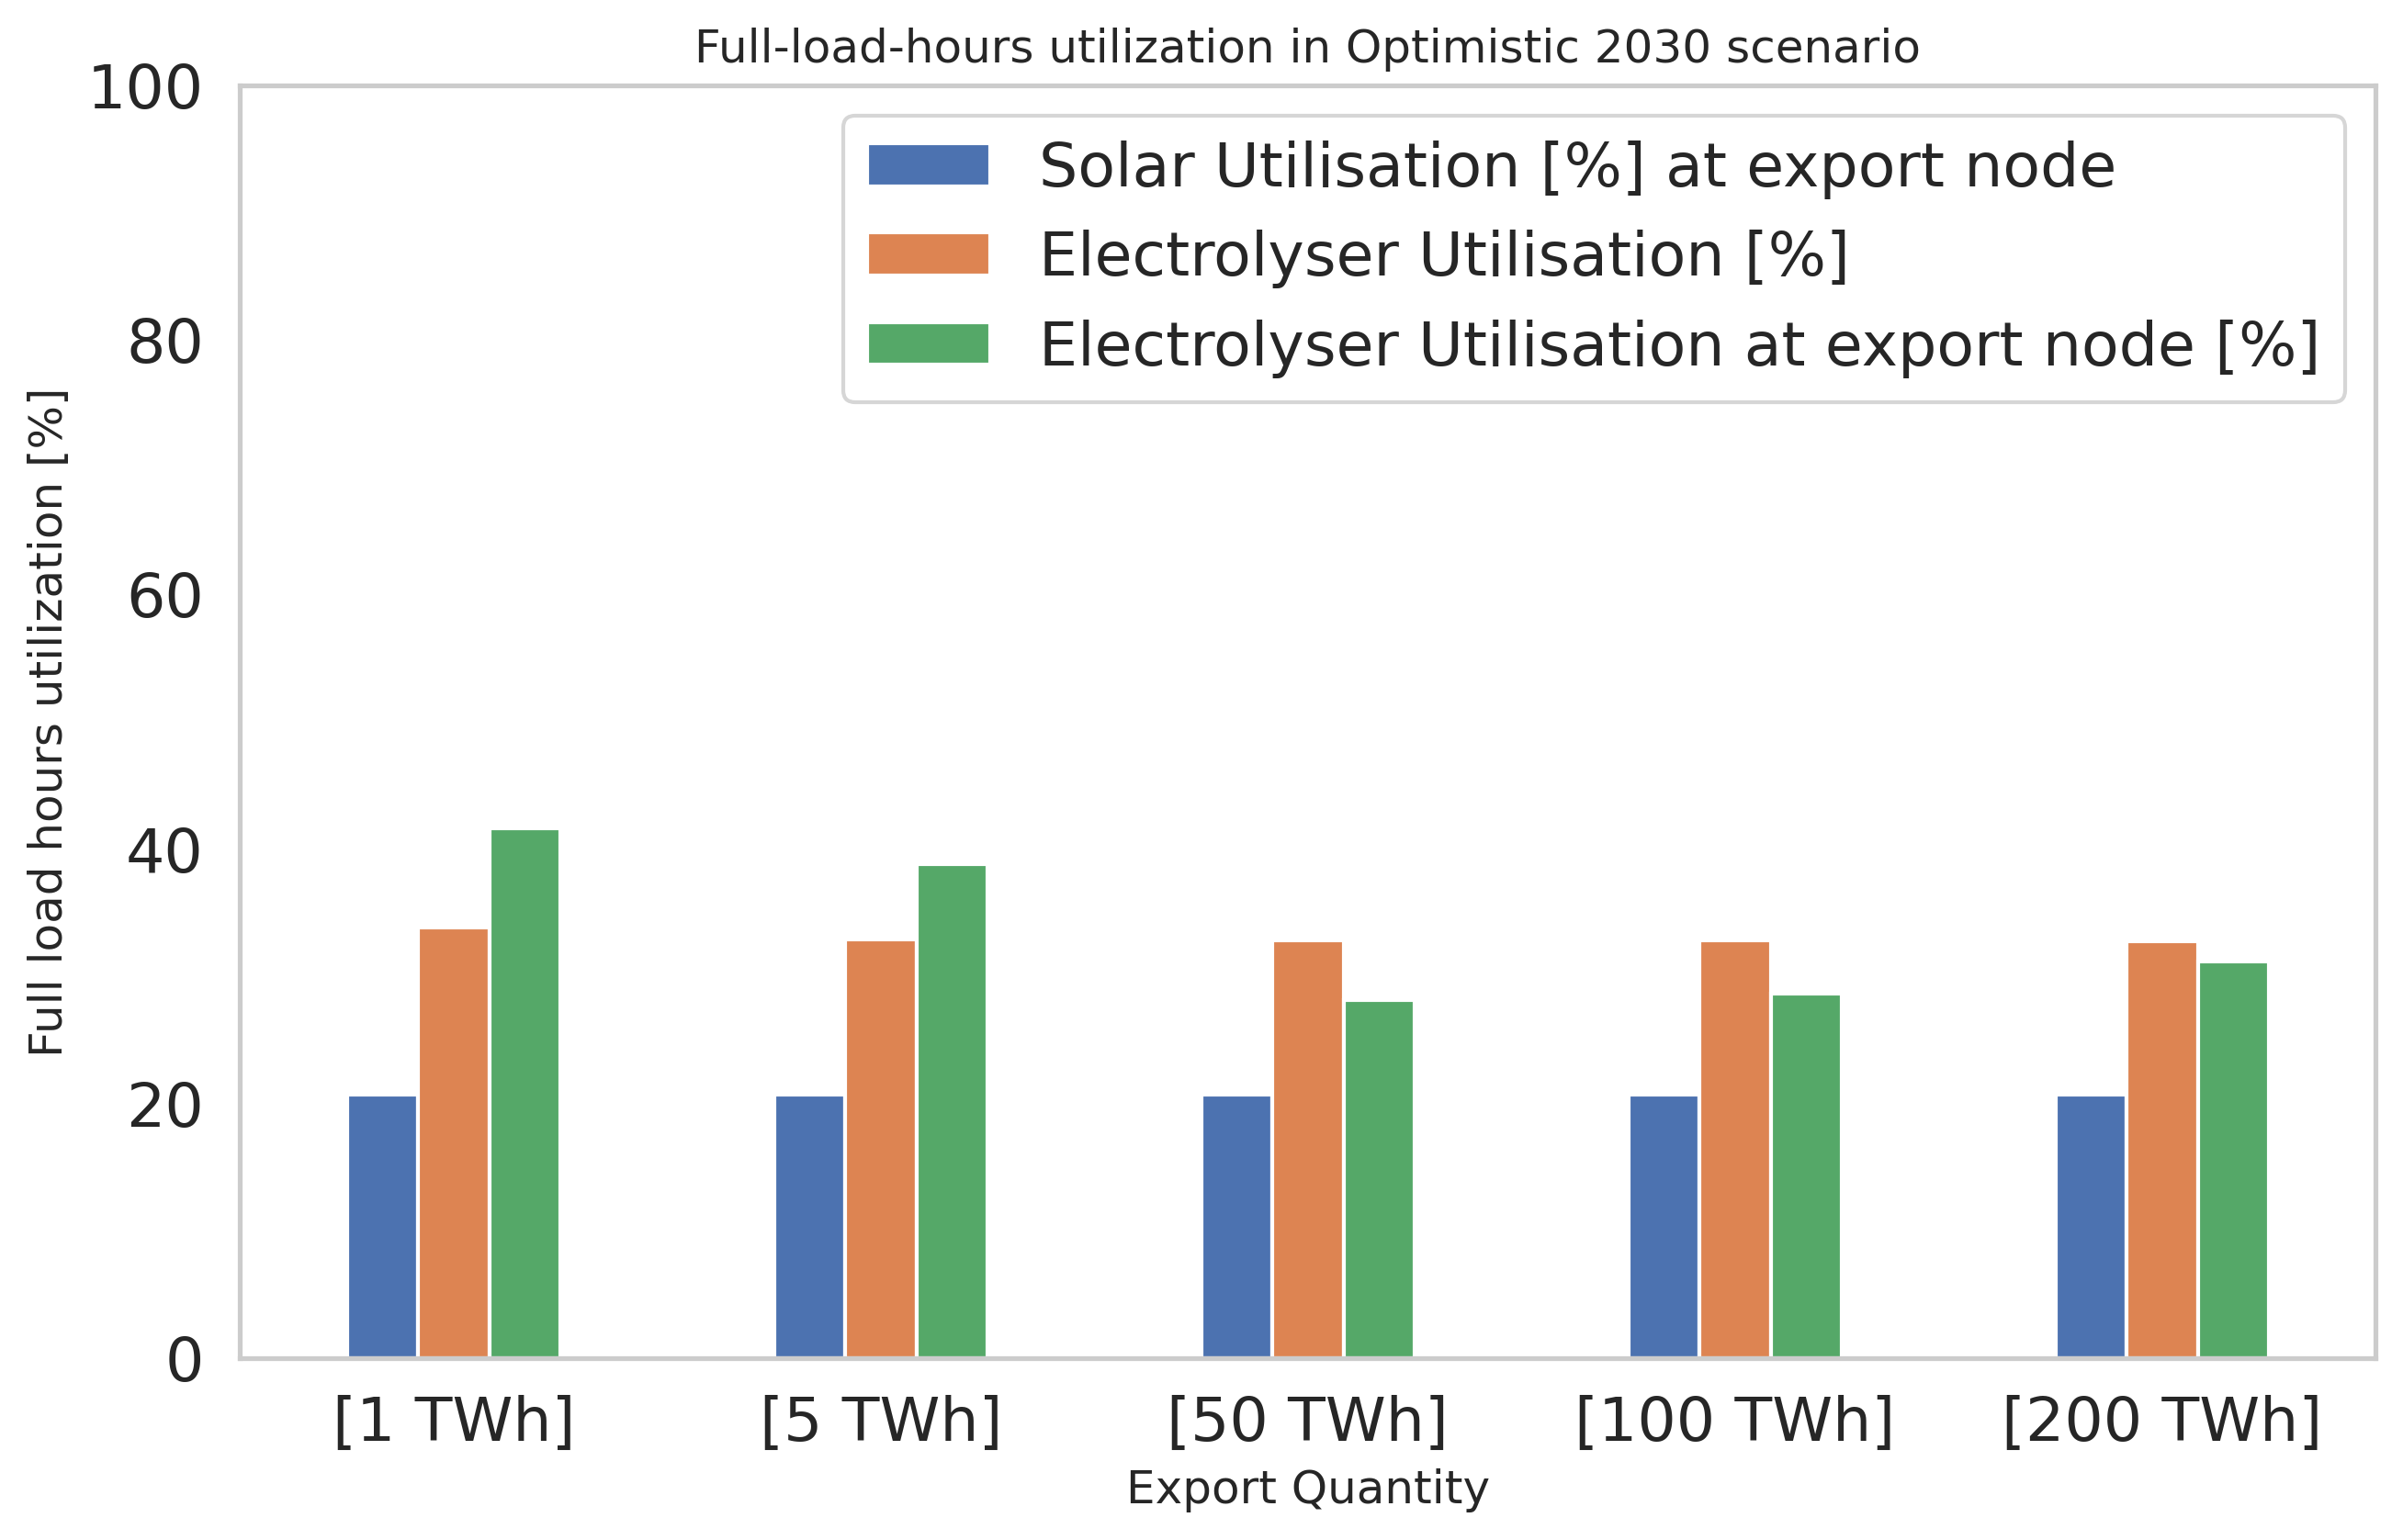

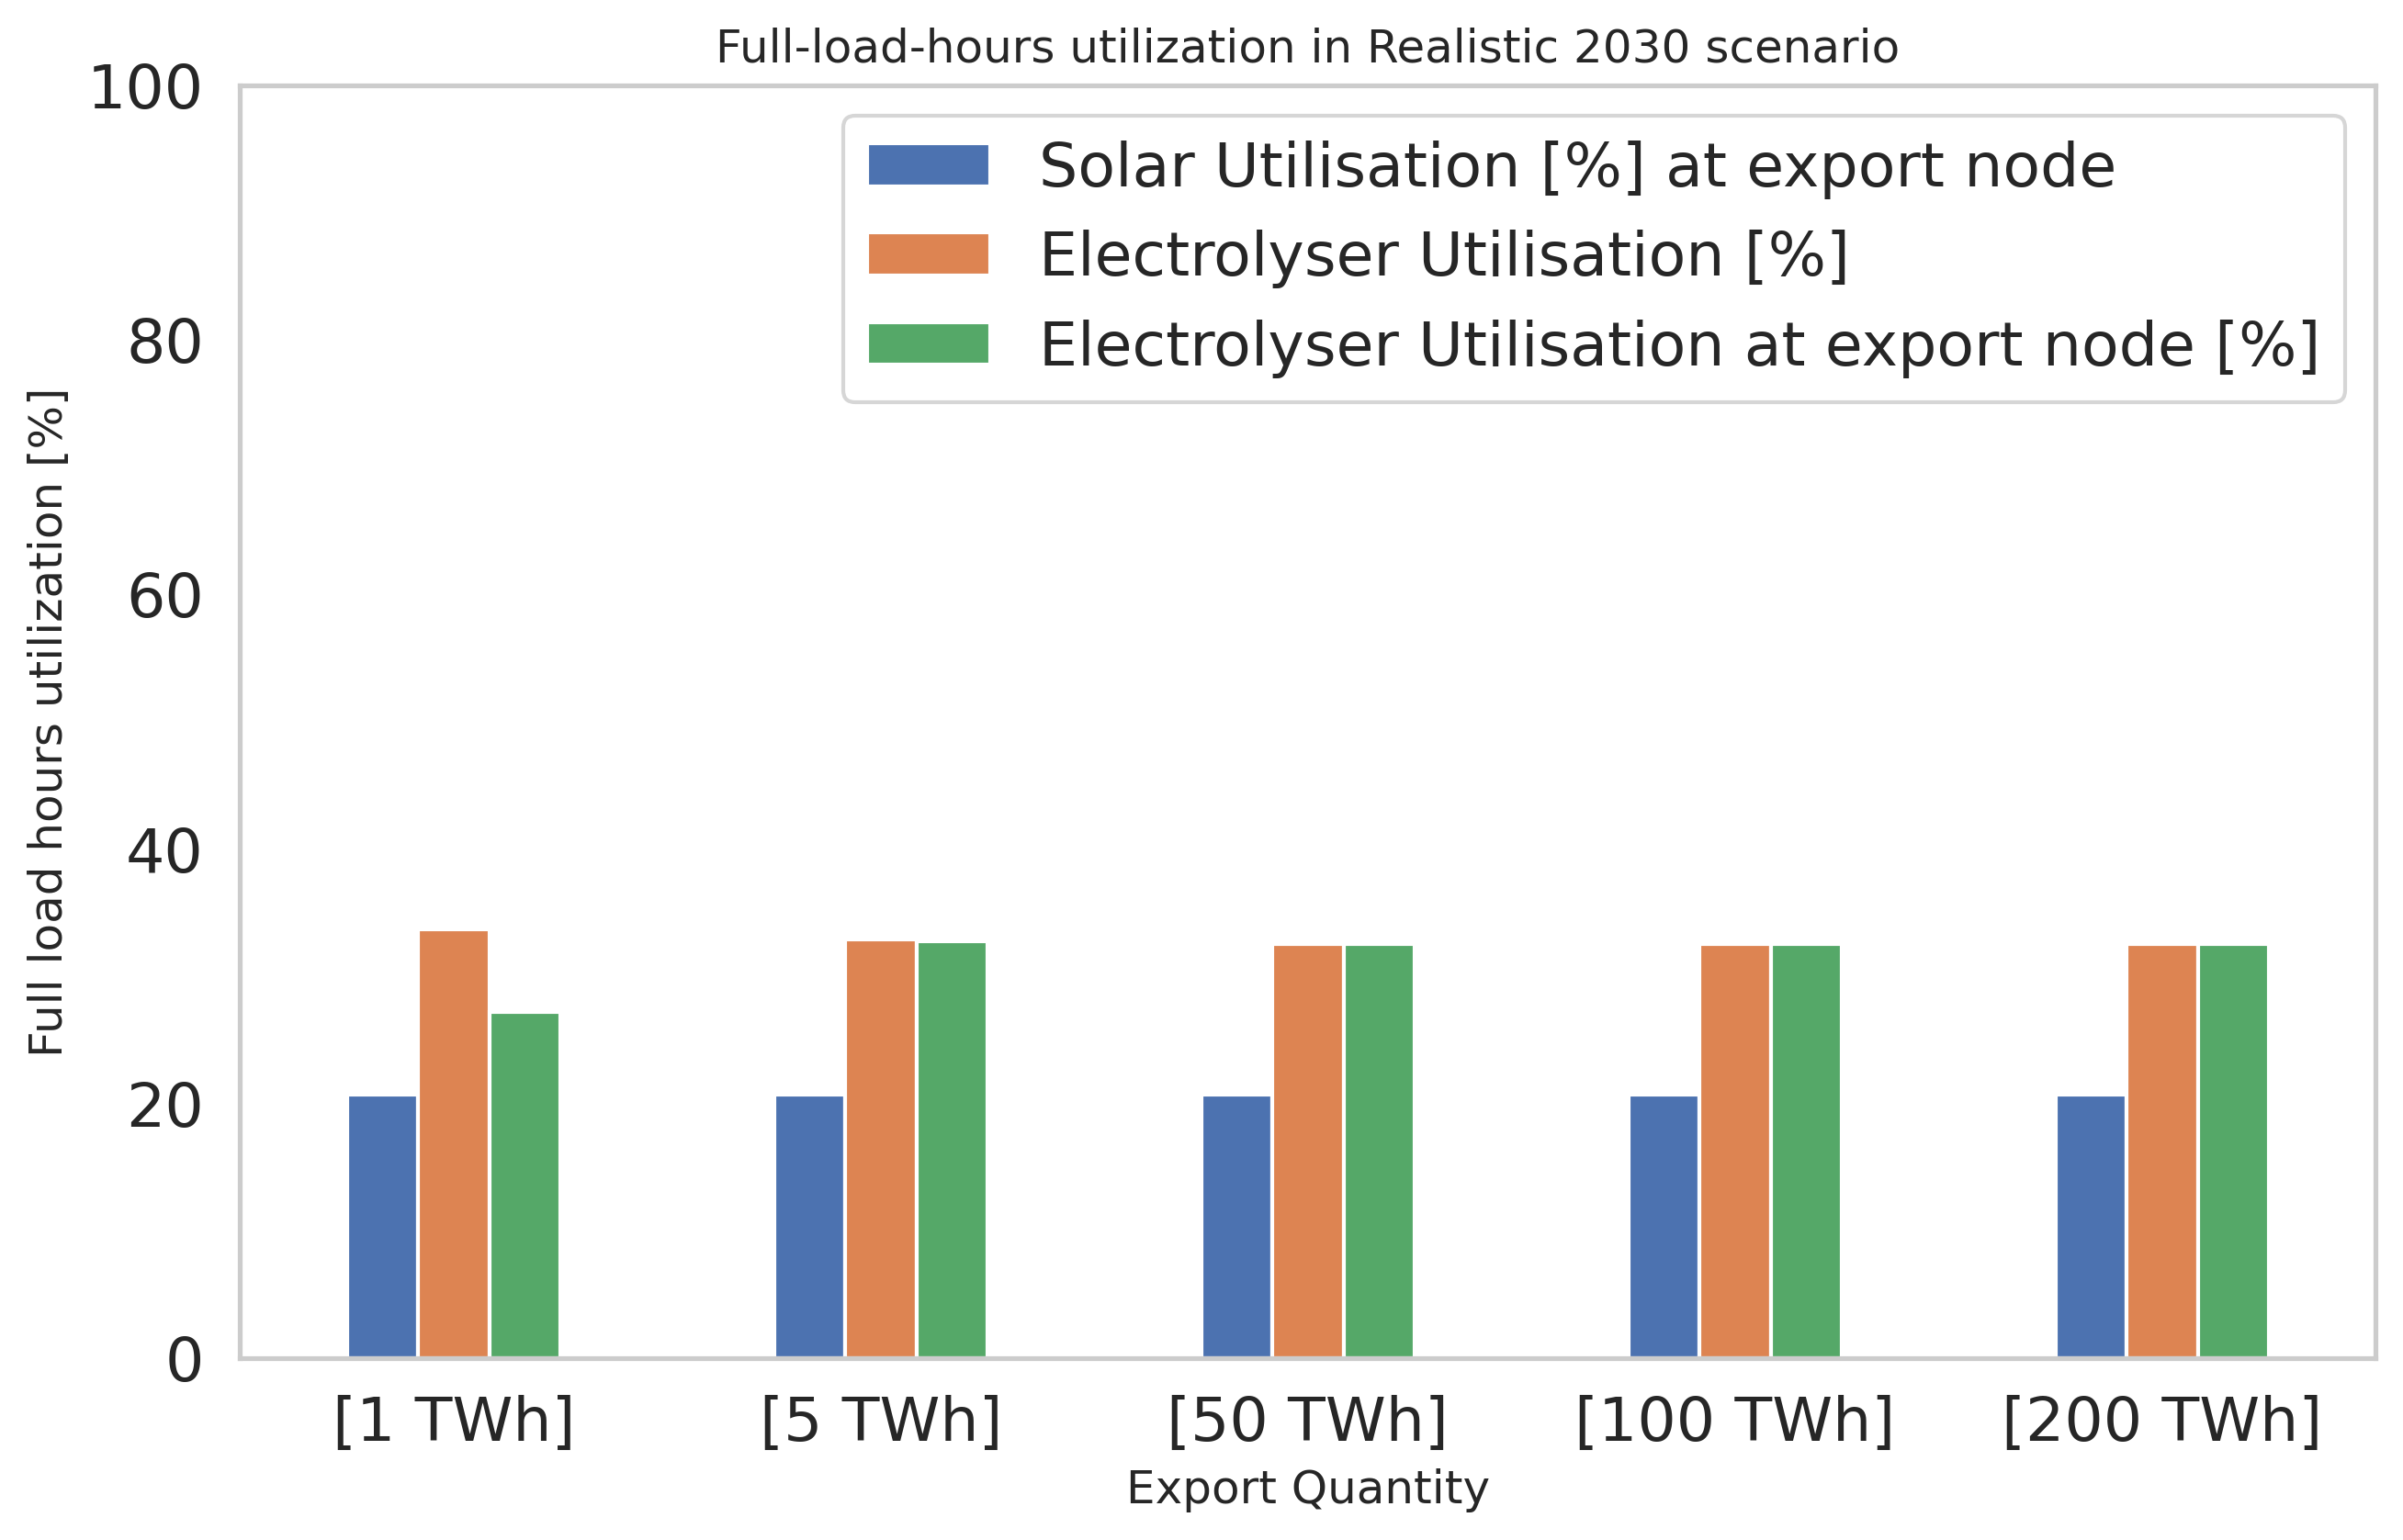

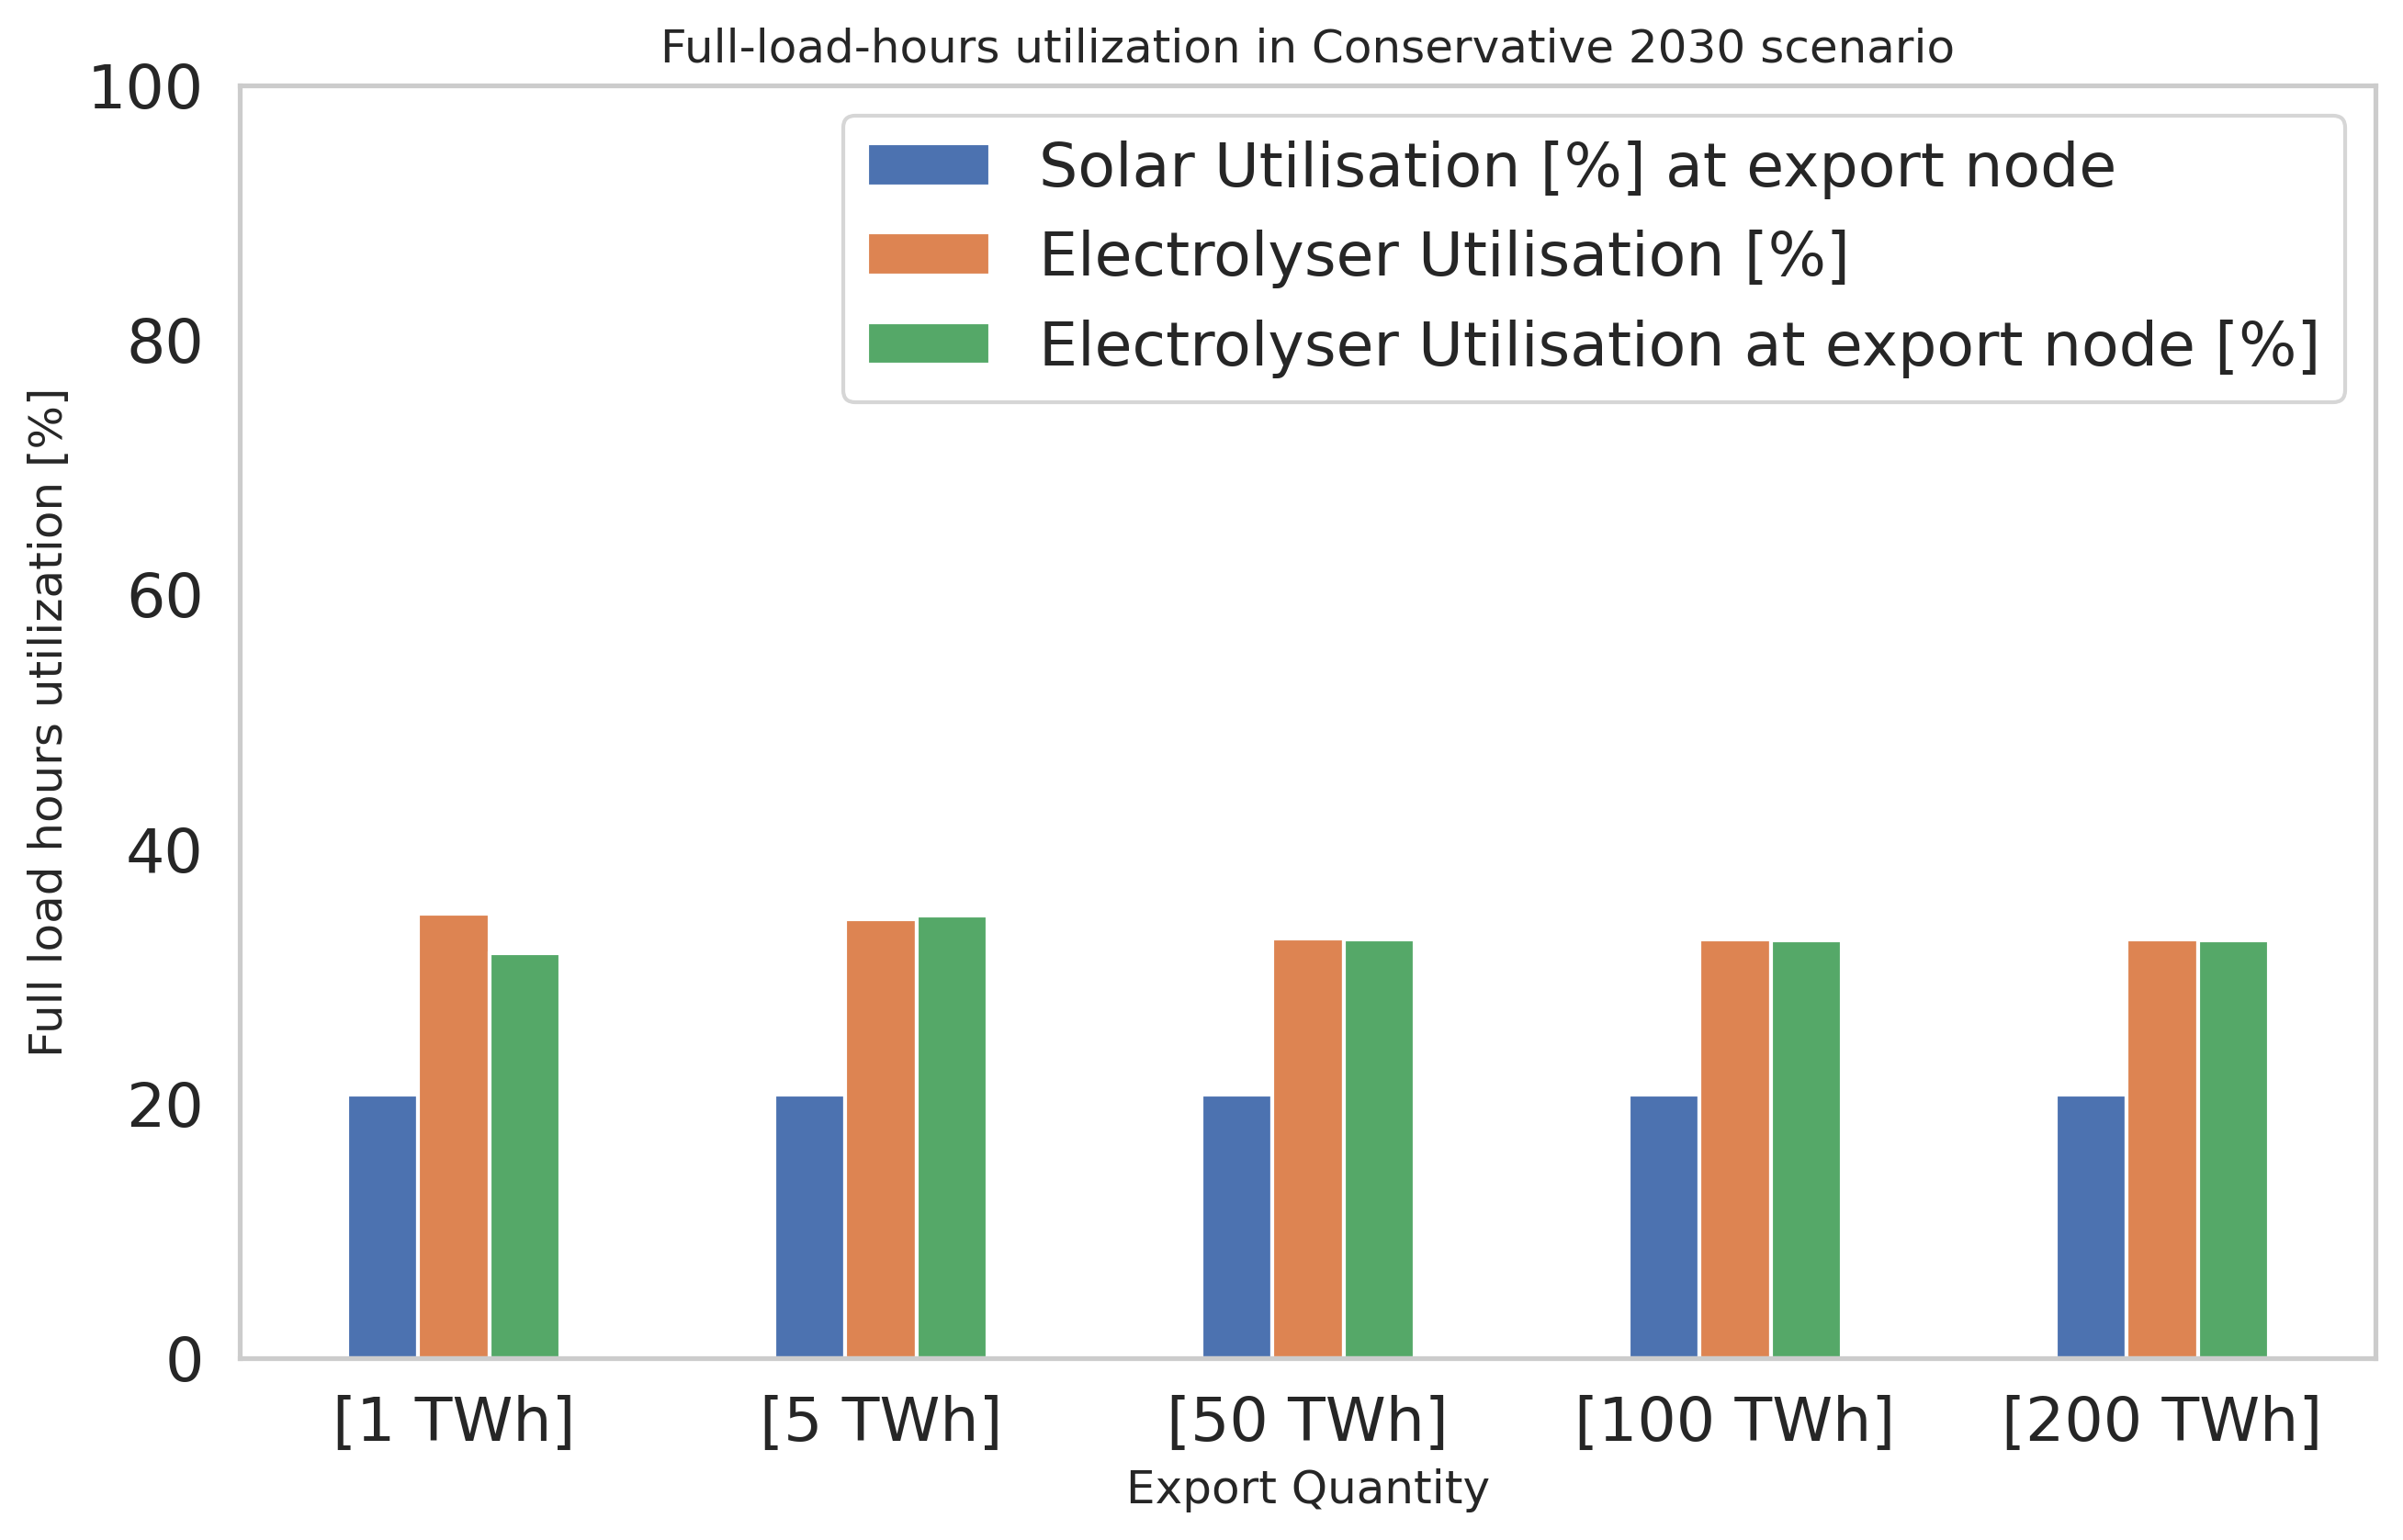

In [33]:
def plot_flh_util(Q30, res_techs, scen_dict,pes_dir):
    for pathway in scen_dict.keys():
        df = pd.DataFrame()
        for q in Q30:
            li = []
            scenario = scen_dict[pathway]
            n = pypsa.Network(pes_dir + "/results/{}/postnetworks/elec_s_{}_ec_lc1.0_Co2L_{}H_2030_{}_{}_{}export.nc".format(scenario["run"], scenario["cluster"], timestep, scenario["ir"], scenario["ds"], q))
            
            #Additional renewable for export quantities
            li.append((1810/8760)*1e2)
            
            #Additional electrolyzer for export quantities
            li.append(calc_elec_capa(n)*1e2)
            li.append(calc_elec_capa_exp(n)*1e2)
            print(li)
            #return pd.DataFrame(li)

            dftemp = pd.DataFrame(li)
            
            dftemp.index = ['Solar Utilisation [%] at export node','Electrolyser Utilisation [%]','Electrolyser Utilisation at export node [%]']
            dftemp.columns=["[{} TWh]".format(q)]
            df = pd.concat([df, dftemp], axis=1) 
        
        dfplot = df.copy()
        #dfplot=dfplot.drop(['CSP Utilisation [%]','Rooftop-solar Utilisation [%]','Onshore wind Utilisation [%]','Onshore wind-2 Utilisation [%]','Offshore wind Utilisation [%]','Onshore wind-2 Utilisation [%]','Hydro Utilisation [%]'])
        #ax = plt.gca()
        ax = dfplot.T.plot(kind="bar", grid=False, legend=True,rot=0,fontsize="medium", xlabel="Export Quantity", ylabel="Full load hours utilization [%]", 
            title = "Full-load-hours utilization in {} scenario".format(pathway), figsize = (10,6), ylim=(0,100)).legend(
        #bbox_to_anchor=(1.0, 1.0),
        fontsize='medium'
        )
        #ax.set_ylim(0,100) 
plot_flh_util(Q30, res_techs, scen_dict,pes_dir)

### Normalized cost of hydrogen at export location

,30,30.1,30.2,30.3,30.4,30.5
0,0.0,2.27,2.62,2.78,2.79,2.79


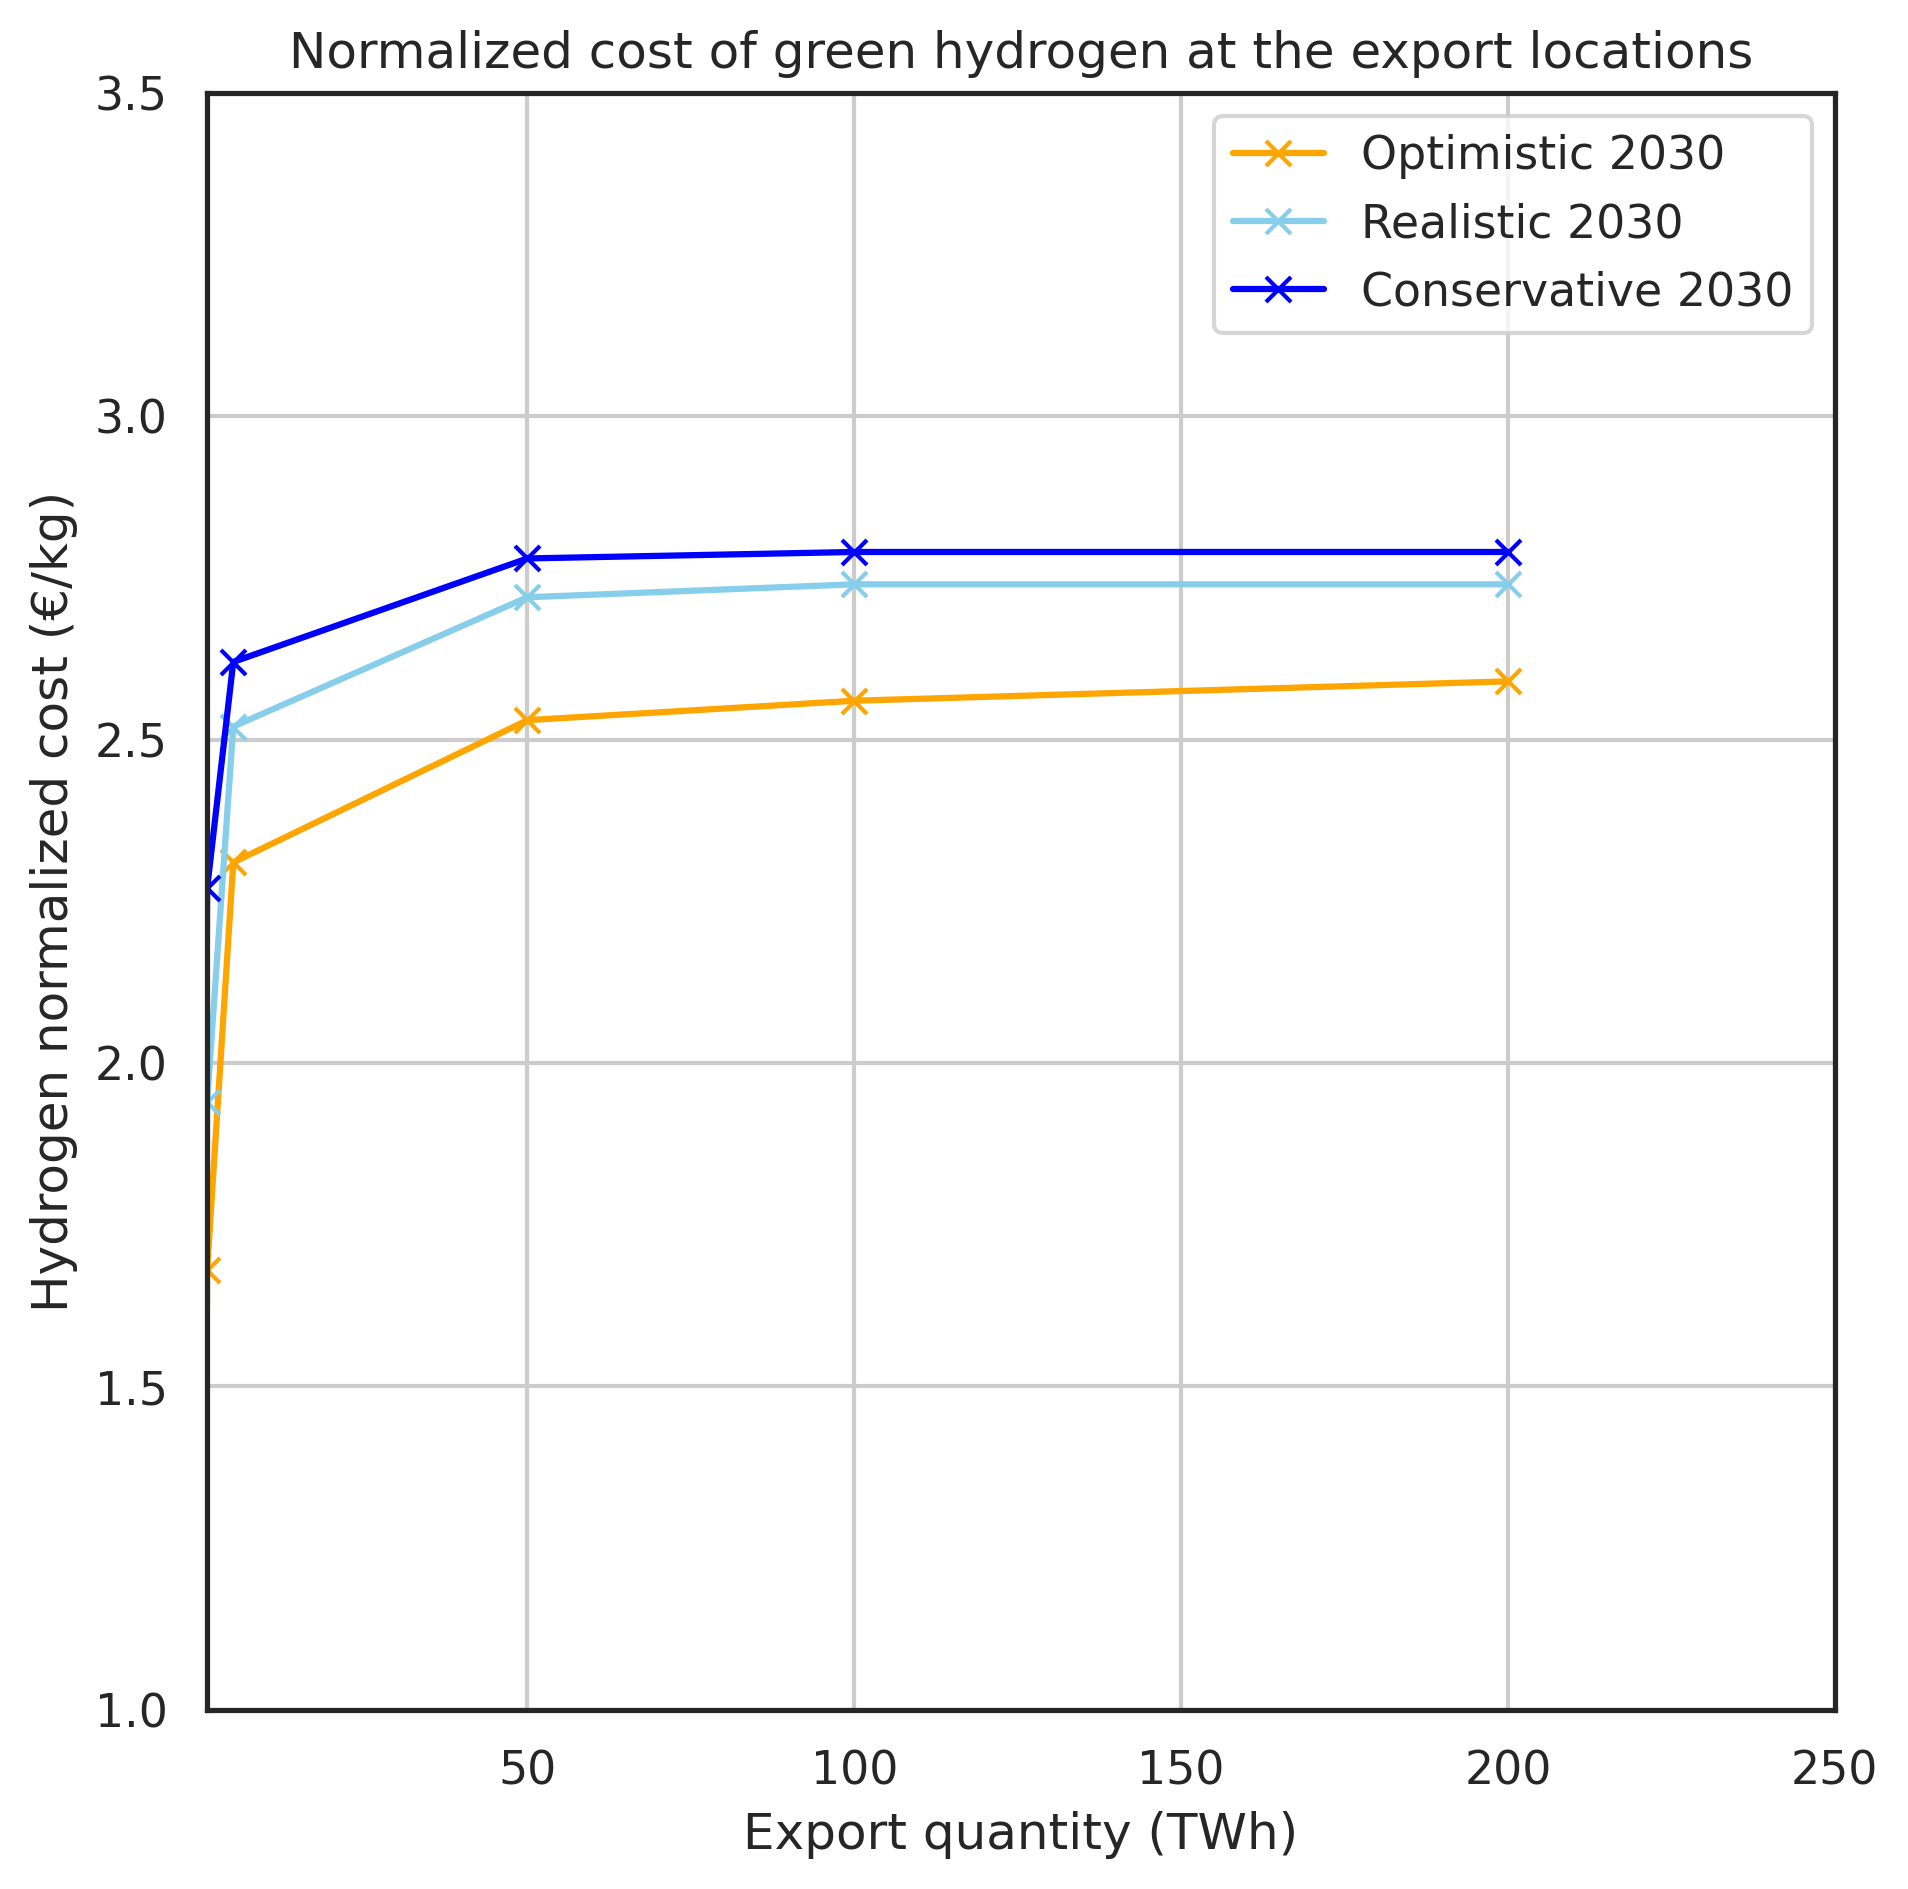

In [17]:
# create figure and axis
def plot_norm_cost_h2(scen_dict,pes_dir):
    fig, ax = plt.subplots(figsize=(7, 7))
    li = []
    for pathway in scen_dict.keys():
        scenario = scen_dict[pathway]
        metrics_opt30 = pes_dir+"/results/{}/csvs/metrics.csv".format(scenario["run"])
        df = pd.read_csv(metrics_opt30, keep_default_na=False,
                na_values=[""])
        df=df.set_index('cluster')
        df = df.loc[['export', 'total costs']]
        df = df.apply(pd.to_numeric)
        #df.columns = ["0","1","5","50", "100", "200"]
        #print(df)
        dfc = [0]
        for column in df.columns[1:]:
            dfc.append(((df.loc["total costs",column].astype(float)- df.loc["total costs", "{}".format(scenario["cluster"])].astype(float)) / (df.loc["export", column] * (1e+09/33.33))).round(2))
        dfc = pd.DataFrame(dfc).transpose()
        dfc.columns = ["{}".format(scenario["cluster"]), "{}.1".format(scenario["cluster"]), "{}.2".format(scenario["cluster"]), "{}.3".format(scenario["cluster"]), "{}.4".format(scenario["cluster"]), "{}.5".format(scenario["cluster"])]
        dfopt = pd.concat([df, dfc], axis=0)
        dfopt.T.plot(ax=ax, x='export', y=0, grid=True, marker="x")
        li.append(pathway)
        out = pd.DataFrame(dfc)
    ax.legend(li);
    #ax.legend(["Realistic 2030", "Conservative 2030"]);
    ax.set_ylabel('Hydrogen normalized cost (€/kg)',fontsize=12)
    ax.set_xlabel('Export quantity (TWh)',fontsize=12)
    ax.set_xlim(1,250)
    ax.set_ylim(1,3.5)
    ax.set_title('Normalized cost of green hydrogen at the export locations')
    return out
plot_norm_cost_h2(scen_dict,pes_dir)

In [8]:
preferred_order = pd.Index(
    [
        "transmission lines",
        "hydroelectricity",
        "hydro reservoir",
        "run of river",
        "pumped hydro storage",
        "solid biomass",
        "biogas",
        "onshore wind",
        "offshore wind",
        "offshore wind (AC)",
        "offshore wind (DC)",
        "solar PV",
        "solar thermal",
        "solar",
        "building retrofitting",
        "ground heat pump",
        "air heat pump",
        "heat pump",
        "resistive heater",
        "power-to-heat",
        "gas-to-power/heat",
        "CHP",
        "OCGT",
        "gas boiler",
        "gas",
        "natural gas",
        "helmeth",
        "methanation",
        "hydrogen storage",
        "power-to-gas",
        "power-to-liquid",
        "battery storage",
        "hot water storage",
        "CO2 sequestration",
    ]
)

def rename_techs(label):
    prefix_to_remove = [
        "residential ",
        "services ",
        "urban ",
        "rural ",
        "central ",
        "decentral ",
    ]

    rename_if_contains = [
        "CHP",
        "gas boiler",
        "biogas",
        "solar thermal",
        "air heat pump",
        "ground heat pump",
        "resistive heater",
        "Fischer-Tropsch",
    ]

    rename_if_contains_dict = {
        "water tanks": "hot water storage",
        "retrofitting": "building retrofitting",
        "H2": "hydrogen storage",
        "battery": "battery storage",
        "CCS": "CCS",
    }

    rename = {
        "solar": "solar PV",
        "Sabatier": "methanation",
        "offwind": "offshore wind",
        "offwind-ac": "offshore wind (AC)",
        "offwind-dc": "offshore wind (DC)",
        "onwind": "onshore wind",
        "ror": "hydroelectricity",
        "hydro": "hydroelectricity",
        "PHS": "hydroelectricity",
        "co2 Store": "DAC",
        "co2 stored": "CO2 sequestration",
        "AC": "transmission lines",
        "DC": "transmission lines",
        "B2B": "transmission lines",
    }

    for ptr in prefix_to_remove:
        if label[: len(ptr)] == ptr:
            label = label[len(ptr) :]

    for rif in rename_if_contains:
        if rif in label:
            label = rif

    for old, new in rename_if_contains_dict.items():
        if old in label:
            label = new

    for old, new in rename.items():
        if old == label:
            label = new
    return label


def rename_techs_tyndp(tech):
    tech = rename_techs(tech)
    if "heat pump" in tech or "resistive heater" in tech:
        return "power-to-heat"
    elif tech in ["methanation", "hydrogen storage", "helmeth"]:
        return "power-to-gas"
    elif tech in ["OCGT", "CHP", "gas boiler"]:
        return "gas-to-power/heat"
    elif "solar" in tech:
        return "solar"
    elif tech == "Fischer-Tropsch":
        return "power-to-liquid"
    elif "offshore wind" in tech:
        return "offshore wind"
    else:
        return tech

def assign_location(n):
    for c in n.iterate_components(n.one_port_components | n.branch_components):
        ifind = pd.Series(c.df.index.str.find(" ", start=4), c.df.index)

        for i in ifind.value_counts().index:
            # these have already been assigned defaults
            if i == -1:
                continue

            names = ifind.index[ifind == i]

            c.df.loc[names, "location"] = names.str[:i]


In [6]:

def calc_cost(network, cost_type="capital", expansion=True): 
    n = network.copy()
    assign_location(n)
    # Drop non-electric buses so they don't clutter the plot
    n.buses.drop(n.buses.index[n.buses.carrier != "AC"], inplace=True)
    print(cost_type == "capital")
    costs = pd.DataFrame(index=n.buses.index)
    components=[
        #"links",
        "generators",
        "stores", 
        #"storage_units"
         ] #TODO uncomment after adding storage units
    for comp in components:
        df_c = getattr(n, comp)#
        
        df_c["nice_group"] = df_c.carrier.map(rename_techs_tyndp)

        attr = "e_nom_opt" if comp == "stores" else "p_nom_opt"
        attr_nom = "e_nom" if comp == "stores" else "p_nom"

        if cost_type == "capital":
            if expansion == True:
                costs_c = (
                (df_c.capital_cost * (df_c[attr] - df_c[attr_nom]))
                .groupby([df_c.location, df_c.nice_group])
                .sum()
                .unstack()
                .fillna(0.0)
            )
            else:
                costs_c = (
                    (df_c.capital_cost * df_c[attr])
                    .groupby([df_c.location, df_c.nice_group])
                    .sum()
                    .unstack()
                    .fillna(0.0)
                )
        else: # cost_type == "marginal":

            df_t={"links": n.links_t, "generators": n.generators_t, "stores": n.stores_t, "storage_units": n.storage_units_t}
            attr = "p0" if comp == "links" else "p" 
            df_c_t = df_t[comp]

            costs_c = (
                #(df_c.marginal_cost * df_c_t[attr])
                (df_c.marginal_cost*(df_c_t[attr].T*n.snapshot_weightings.generators).T)

                #.groupby([df_c.location, df_c.nice_group])
                .sum()
                #.unstack()
                #.fillna(0.0)
            )
            
            #print(costs_c)
        costs = pd.concat([costs, costs_c], axis=1)

        #print(comp, costs)
    costs = costs.groupby(costs.columns, axis=1).sum()

    costs.drop(list(costs.columns[(costs == 0.0).all()]), axis=1, inplace=True)

    new_columns = preferred_order.intersection(costs.columns).append(
        costs.columns.difference(preferred_order)
    )
    costs = costs[new_columns]

    #for item in new_columns:
    #    if item not in tech_colors:
    #        print("Warning!", item, "not in config/plotting/tech_colors")

    #costs = costs.stack()
    
    return costs# .sort_index()

# exp_false = calc_cost(n, cost_type="marginal", expansion=False)
# exp_false
#exp_false.sum().plot(kind="bar")
#exp_false = calc_cost(n, cost_type="marginal", expansion=False)

#exp_true.filter(regex = ' ror$', axis=0)
#exp_false.filter(regex = ' ror$', axis=0)


In [20]:
exp_false = calc_cost(n, cost_type="marginal", expansion=True)


False


In [21]:
#exp_false.index = exp_false.index.str.extract(r'\s.*')
exp_false.index = exp_false.index.str.split().str[1:].str.join(' ')
exp_false = exp_false.groupby(exp_false.index).sum().sort_values(by=0, ascending=False).T
exp_false*1e-9

,oil Store,solid biomass,gas,biogas,solar,oil,coal,ror,onwind,csp,onwind2,urban central solar thermal collector,residential rural solar thermal collector,services urban decentral solar thermal collector,services rural solar thermal collector,residential urban decentral solar thermal collector,rooftop-solar,offwind,offwind2,H2 Store,gas Store,battery,,co2 stored,battery storage,export store,urban central water tanks,services rural water tanks,residential urban decentral water tanks,services urban decentral water tanks,residential rural water tanks,atmosphere
0,0.638193,0.039721,0.035833,0.012852,0.003077,0.000227,0.000165,0.000017,9.331978e-08,1.134065e-09,9.351628e-10,4.681215e-10,3.811284e-10,2.974217e-10,2.940754e-10,2.931297e-10,2.114132e-10,1.921730e-10,8.178894e-11,4.345936e-21,1.163514e-22,2.791517e-23,0.0,0.0,-3.486252e-23,-1.658546e-13,-9.678985e-11,-1.896851e-10,-1.967591e-10,-1.976320e-10,-2.051752e-10,-0.000039


In [22]:
exp_false.columns
exp_false.columns = exp_false.columns.str.lstrip(" ")


In [23]:
exp_false.columns

Index(['oil Store', 'solid biomass', 'gas', 'biogas', 'solar', 'oil', 'coal',
       'ror', 'onwind', 'csp', 'onwind2',
       'urban central solar thermal collector',
       'residential rural solar thermal collector',
       'services urban decentral solar thermal collector',
       'services rural solar thermal collector',
       'residential urban decentral solar thermal collector', 'rooftop-solar',
       'offwind', 'offwind2', 'H2 Store', 'gas Store', 'battery', '',
       'co2 stored', 'battery storage', 'export store',
       'urban central water tanks', 'services rural water tanks',
       'residential urban decentral water tanks',
       'services urban decentral water tanks', 'residential rural water tanks',
       'atmosphere'],
      dtype='object')

INFO:pypsa.io:Imported network elec_s_30_ec_lc1.0_Co2L_3H_2030_0.076_NZ_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores


True


INFO:pypsa.io:Imported network elec_s_30_ec_lc1.0_Co2L_3H_2030_0.082_AP_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores


True


INFO:pypsa.io:Imported network elec_s_30_ec_lc1.0_Co2L_3H_2030_0.097_AP_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores


True


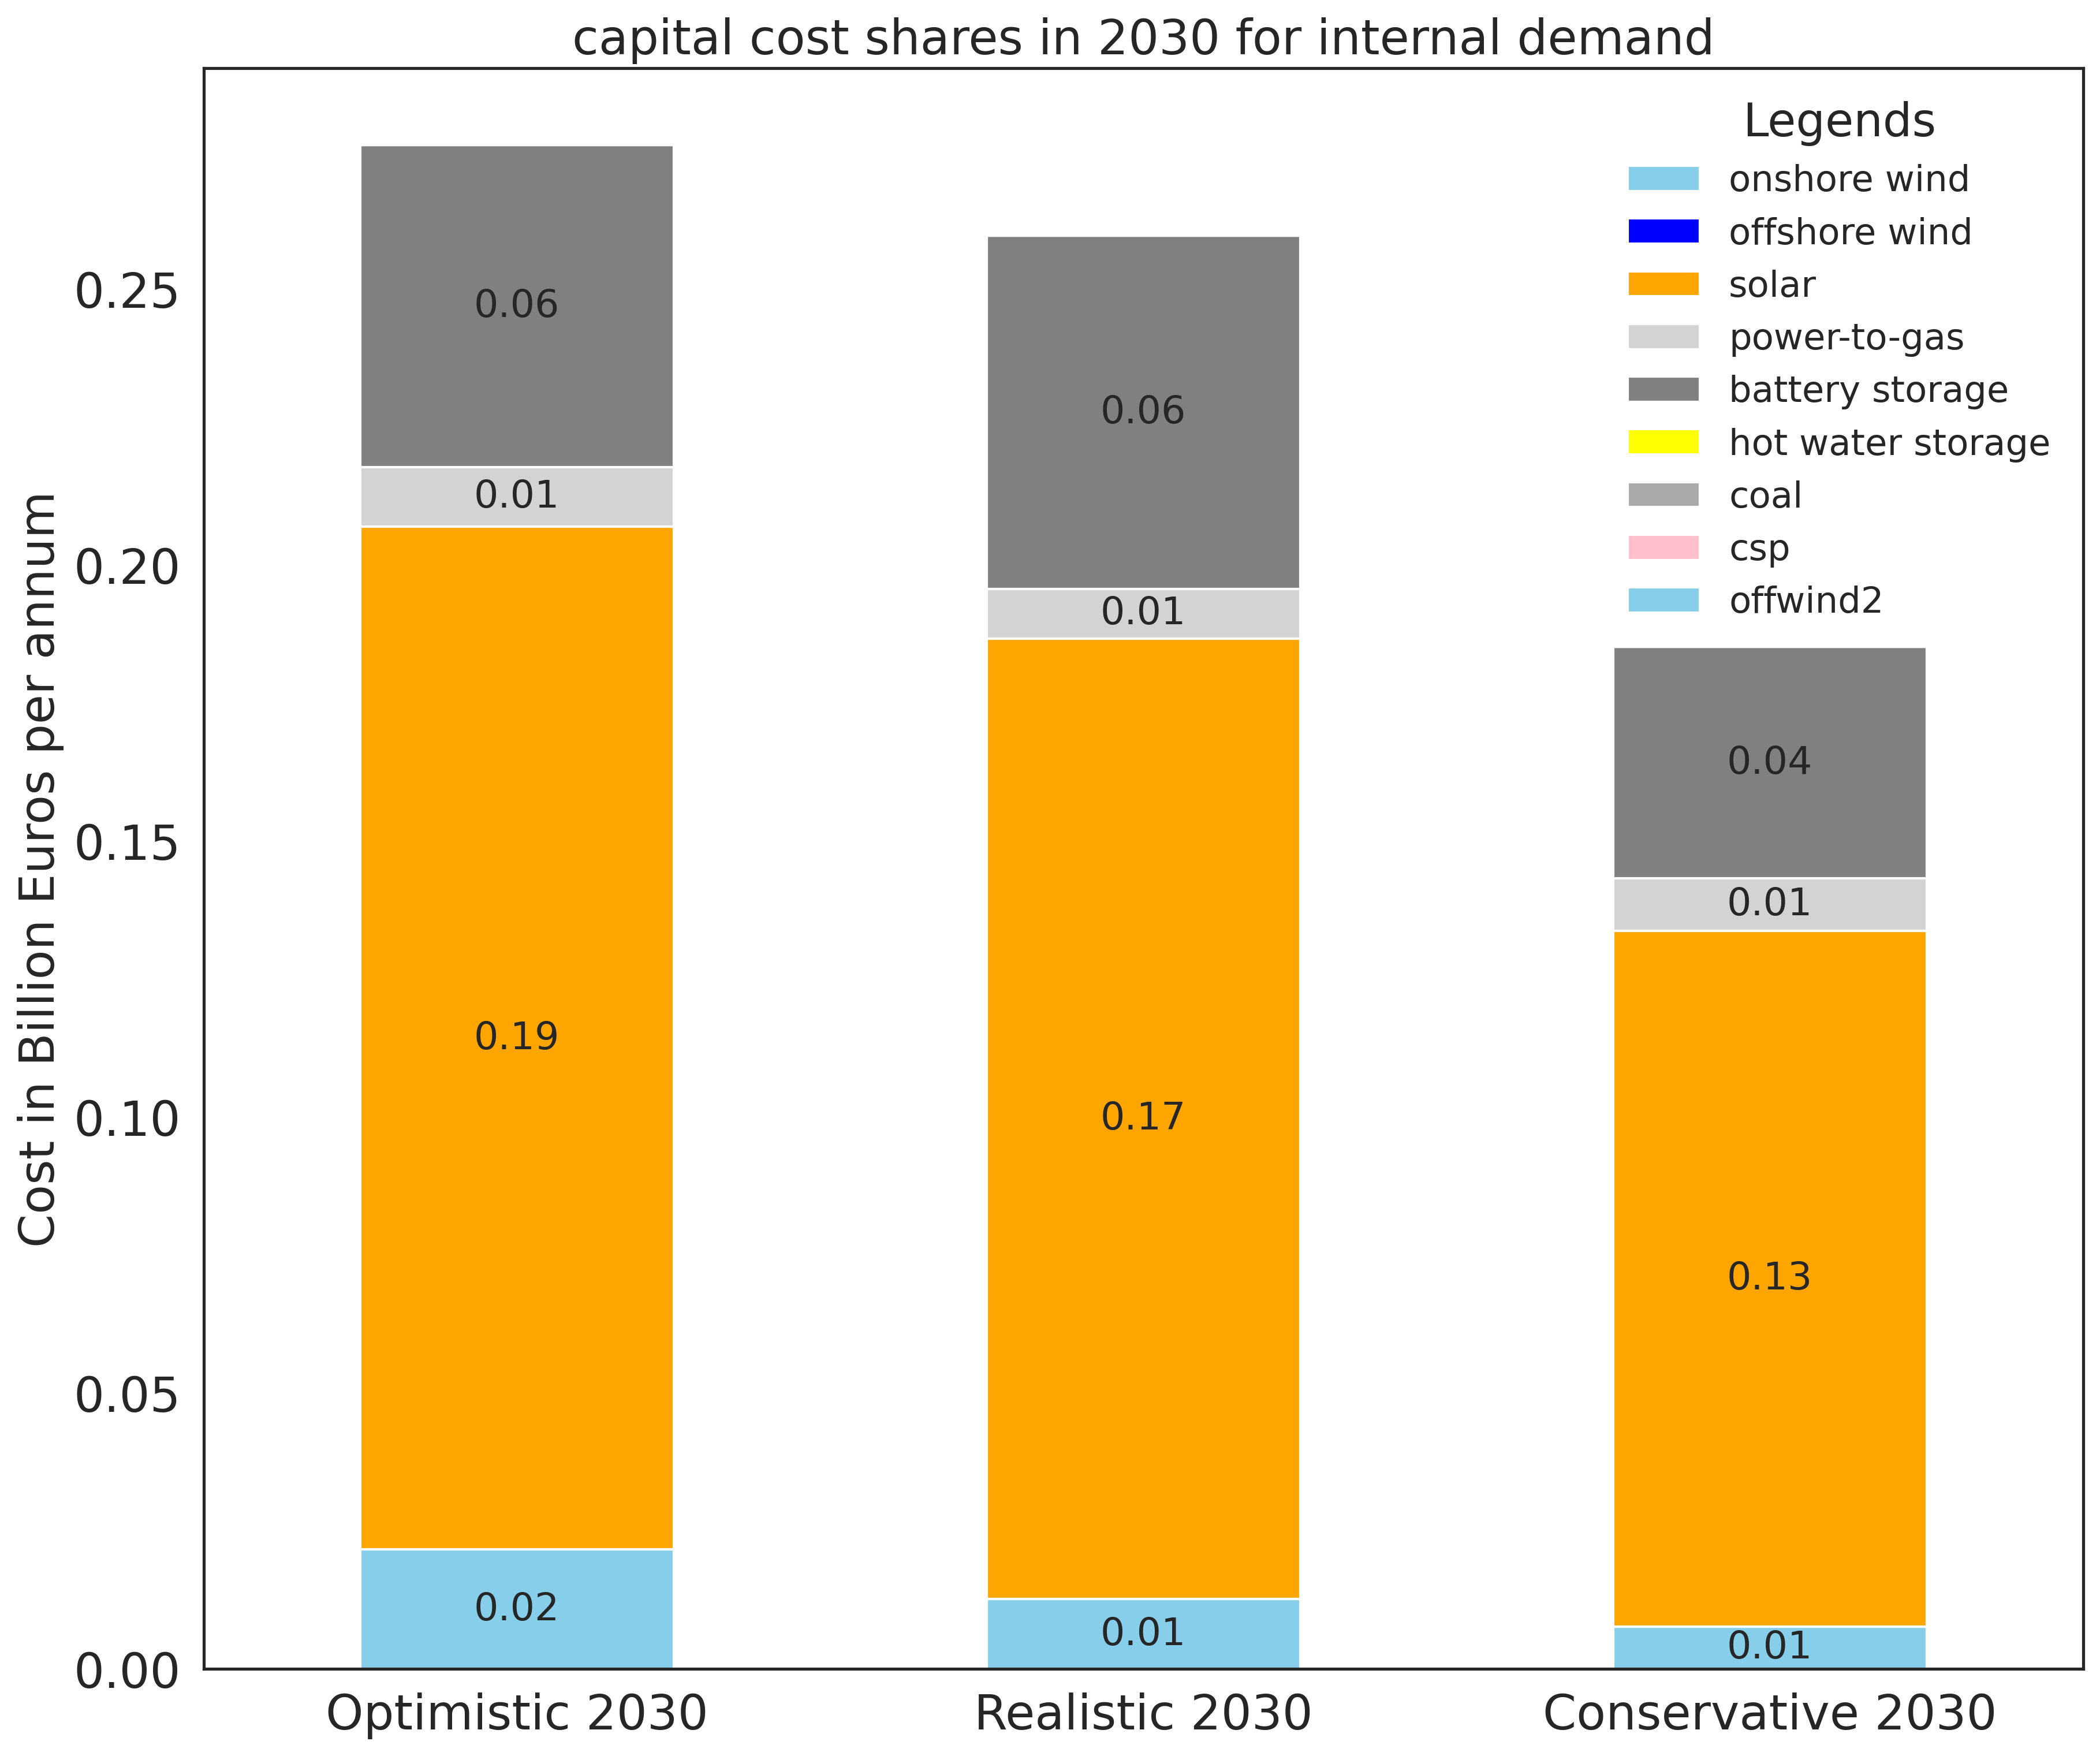

In [9]:
def plot_cost(cost):
    df = pd.DataFrame()
    for pathway in scen_dict.keys():
        li = []
        scenario = scen_dict[pathway]
        n = pypsa.Network(pes_dir + "/results/{}/postnetworks/elec_s_{}_ec_lc1.0_Co2L_{}H_2030_{}_{}_0export.nc".format(scenario["run"], scenario["cluster"], timestep, scenario["ir"], scenario["ds"]))
        cc = calc_cost(n, cost_type=cost, expansion=True)
        li.append(cc.sum()*1e-9)
        dftemp = pd.DataFrame(li)
        dftemp.index=[pathway]
        df=pd.concat([df, dftemp]) 
    import seaborn as sns
    sns.set_style("white")

    colors = ["skyblue", "blue", "orange", "lightgray", "gray", "yellow", "darkgray", "pink", "skyblue", "brown","blue" ]
    label = ['onshore wind', 'offshore wind','solar', 'power-to-gas', 'battery storage' , 'hot water storage', 'coal', 'csp', "offwind2", 'oil','onwind2' ]
    sns.set_palette(sns.color_palette(colors))
    ax = df.plot(kind= "bar",stacked=True, figsize=(14,12), fontsize=20, rot=0, title="{} cost shares in 2030 for internal demand".format(cost), ylabel="Cost in Billion Euros per annum")
    ax.title.set_size(20)
    ax.yaxis.get_label().set_fontsize(20)
    for c in ax.containers:

        # Optional: if the segment is small or 0, customize the labels
        labels = [v.get_height().round(2) if v.get_height().round(2) > 0 else '' for v in c]
        
        # remove the labels parameter if it's not needed for customized labels
        ax.bar_label(c, labels=labels, label_type='center')
    plt.legend(
        labels=label,
        ncol=1,
        fontsize=15,
        title='Legends',
        title_fontsize='large', frameon= False, bbox_to_anchor=(1.0, 1.0))
    plt.rcParams["figure.dpi"] = 300
    plt.show()
plot_cost("capital")

INFO:pypsa.io:Imported network elec_s_30_ec_lc1.0_Co2L_3H_2030_0.076_NZ_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores


False
Index(['oil Store', 'solid biomass', 'gas', 'biogas', 'coal'], dtype='object')


INFO:pypsa.io:Imported network elec_s_30_ec_lc1.0_Co2L_3H_2030_0.082_AP_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores


False
Index(['oil Store', 'gas', 'solid biomass', 'biogas', 'coal'], dtype='object')


INFO:pypsa.io:Imported network elec_s_30_ec_lc1.0_Co2L_3H_2030_0.097_AP_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores


False
Index(['oil Store', 'gas', 'solid biomass', 'coal', 'oil'], dtype='object')


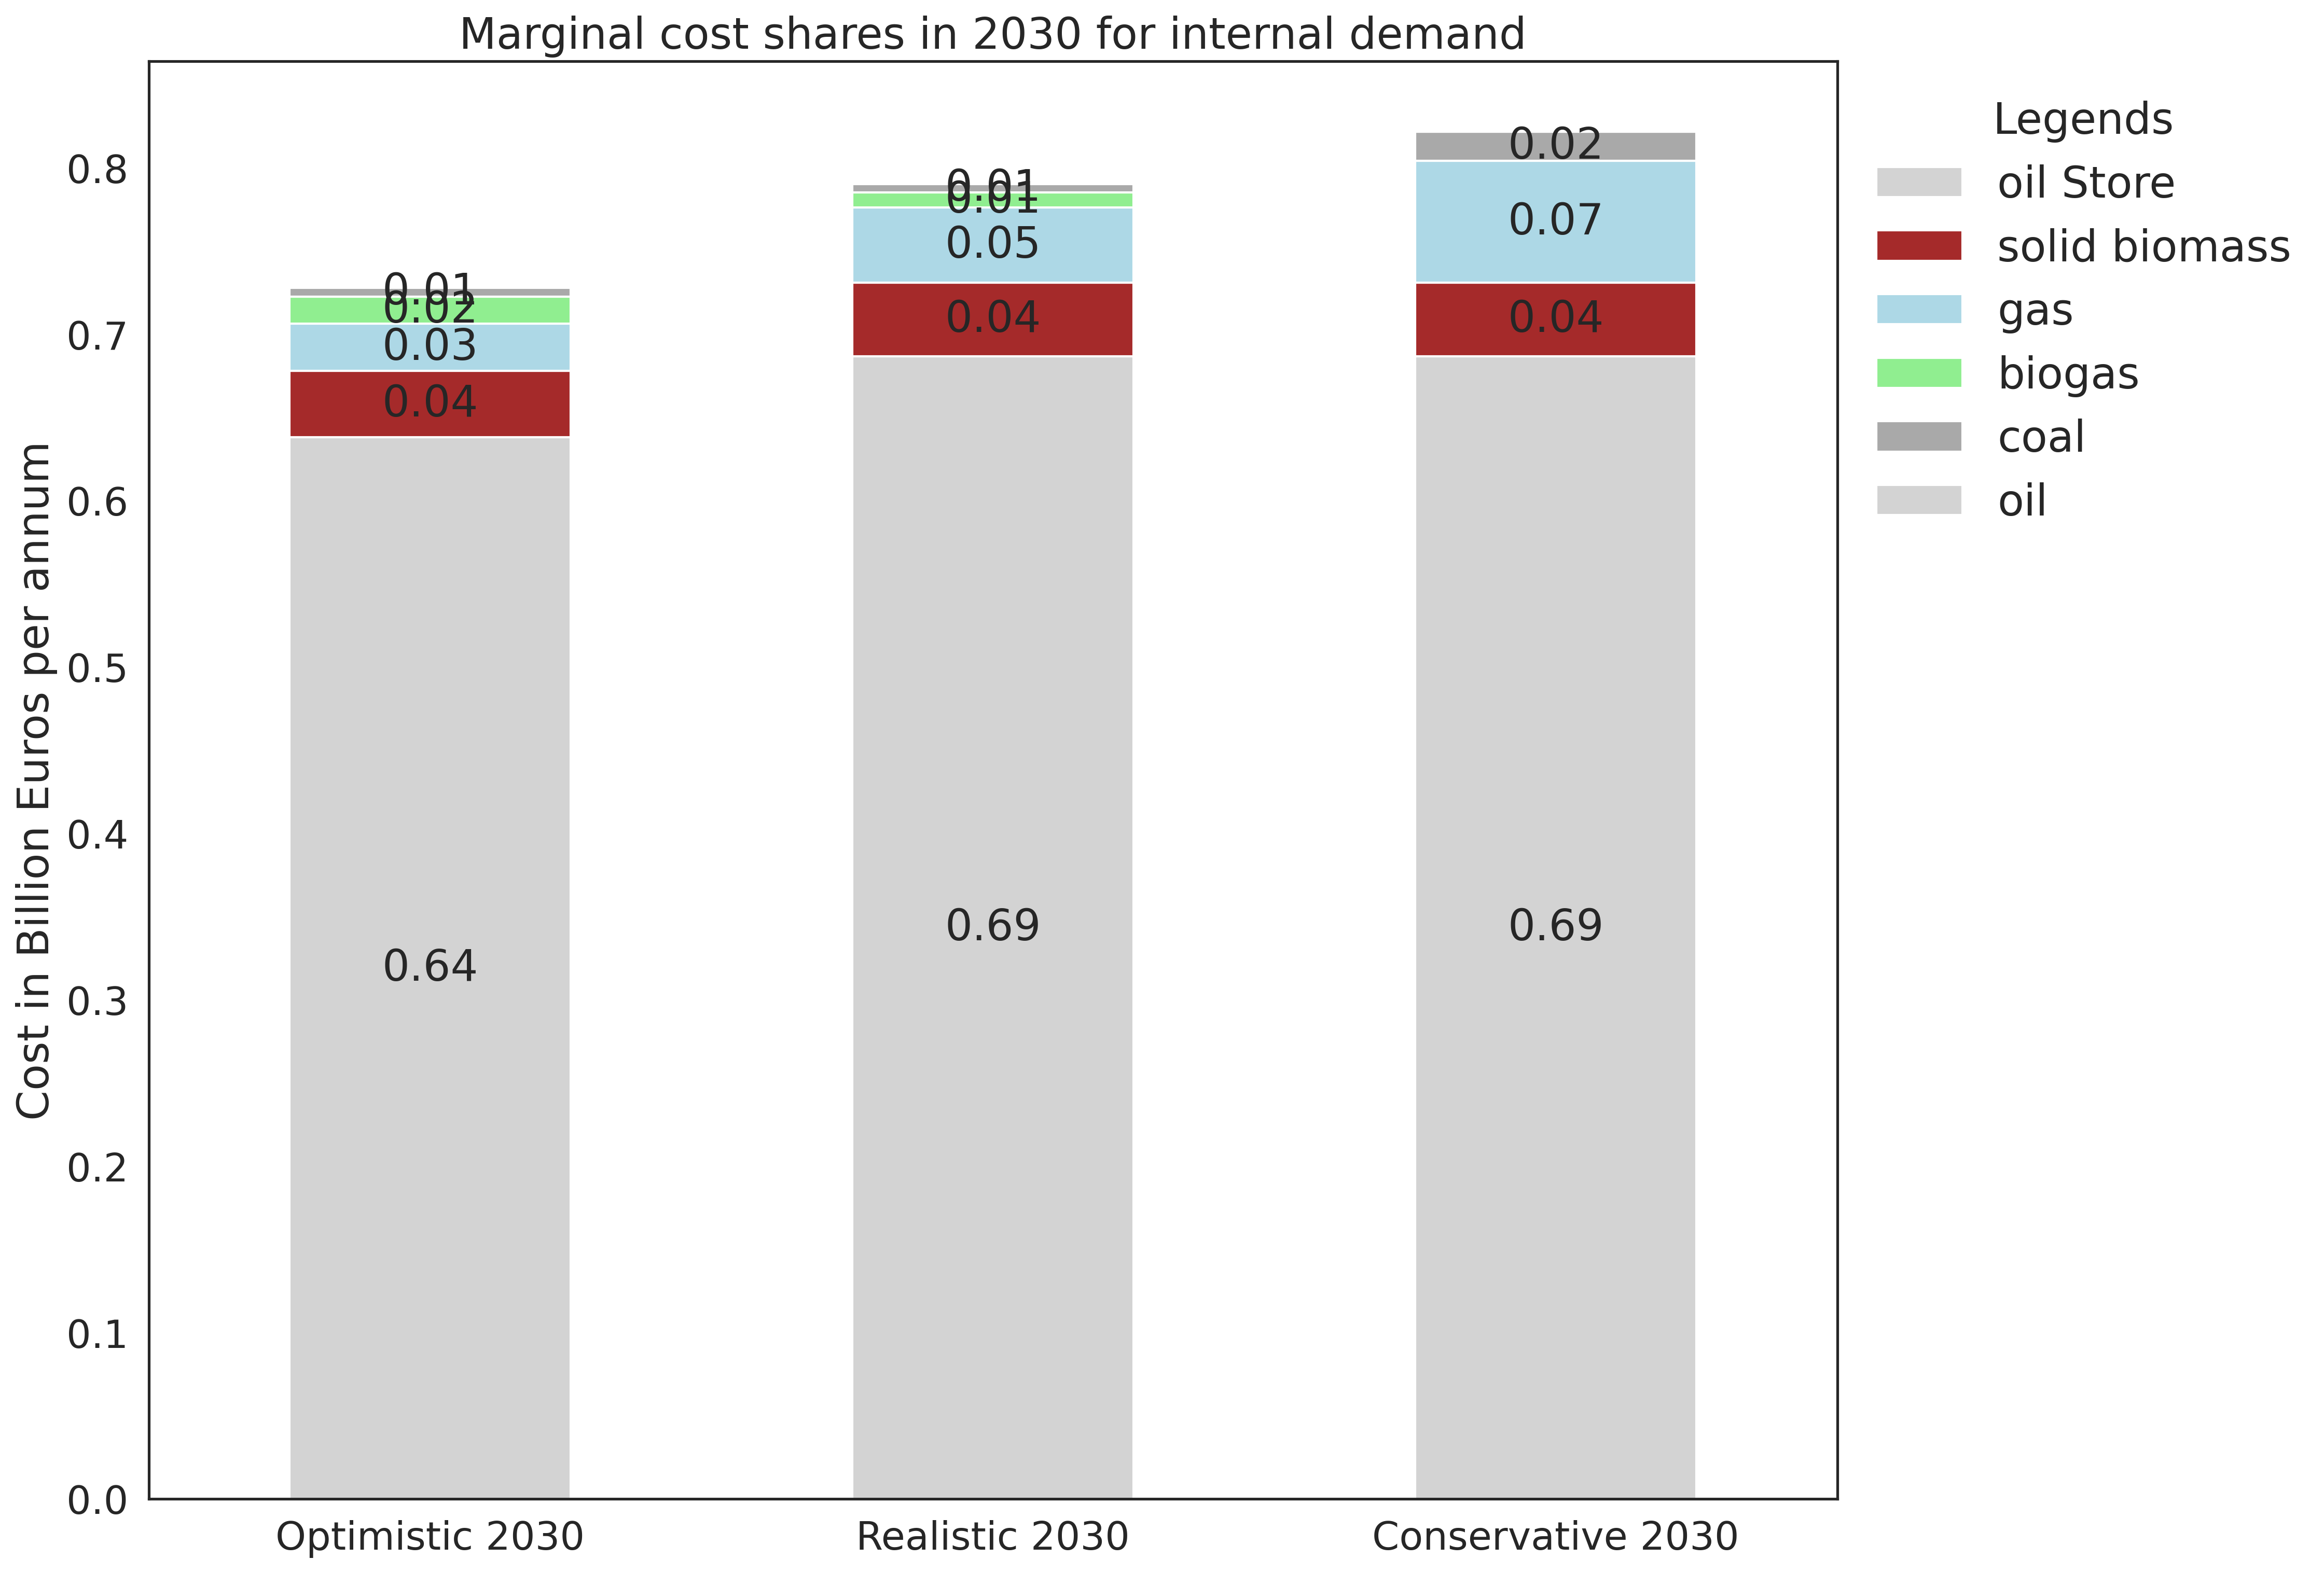

,oil Store,solid biomass,gas,biogas,coal,oil
Optimistic 2030,0.638187,0.039720,0.028434,0.016415,0.005092,NaN
Realistic 2030,0.686637,0.044255,0.045275,0.009018,0.005158,NaN
Conservative 2030,0.686642,0.044256,0.073508,NaN,0.017329,0.001101


In [10]:
import seaborn as sns
sns.set_style("white")
df = pd.DataFrame()
for pathway in scen_dict.keys():
    li = []
    scenario = scen_dict[pathway]
    n = pypsa.Network(pes_dir + "/results/{}/postnetworks/elec_s_{}_ec_lc1.0_Co2L_{}H_2030_{}_{}_0export.nc".format(scenario["run"], scenario["cluster"], timestep, scenario["ir"], scenario["ds"]))
    exp_false = calc_cost(n, cost_type="marginal", expansion=True)
    exp_false.index = exp_false.index.str.split().str[1:].str.join(' ')
    dftemp = (exp_false.groupby(exp_false.index).sum().sort_values(by=0, ascending=False).head(5).T*1e-9)
    #dftemp = dftemp.head(5)
    print(dftemp.columns)
    #li.append(exp_false)
    #dftemp = pd.DataFrame(li)
    dftemp.index=[pathway]
    df=pd.concat([df, dftemp]) 
colors = ["lightgray", "brown", "lightblue", "lightgreen", "darkgray", "lightgray"]
label = ['oil Store', 'solid biomass','gas', 'biogas', 'coal' , 'oil']
sns.set_palette(sns.color_palette(colors))
ax = df.plot(kind= "bar",stacked=True, figsize=(14,12), fontsize=18,rot=0, title="Marginal cost shares in 2030 for internal demand", ylabel="Cost in Billion Euros per annum")
ax.title.set_size(20)
ax.yaxis.get_label().set_fontsize(20)
for c in ax.containers:

    # Optional: if the segment is small or 0, customize the labels
    labels = [v.get_height().round(2) if v.get_height().round(2) > 0 else '' for v in c]
    
    # remove the labels parameter if it's not needed for customized labels
    ax.bar_label(c, labels=labels, label_type='center', fontsize=20)
plt.legend(
    #labels=label,
    ncol=1,
    fontsize=20,
    title='Legends',
    title_fontsize=20, frameon= False, bbox_to_anchor=(1.0, 1.0))
plt.rcParams["figure.dpi"] = 300
plt.show()
df

In [26]:

### Import packages
#Import packages
import os
import sys
import logging
import pypsa
import yaml
import pandas as pd
import geopandas as gpd
import numpy as np
import scipy as sp
import networkx as nx
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.io.img_tiles import OSM
import cartopy.feature as cfeature

from scipy.sparse import csgraph
from itertools import product
import re

from shapely.geometry import Point, LineString
import shapely, shapely.prepared
from shapely.wkt import loads
from shapely.validation import make_valid

logger = logging.getLogger(__name__)

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 70)
#for solved network plot

from matplotlib.patches import Circle, Ellipse
from matplotlib.legend_handler import HandlerPatch
from pypsa.plot import add_legend_circles, add_legend_lines, add_legend_patches
plt.style.use("bmh")

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid", font_scale=1)
### Node query


In [ ]:

n = pypsa.Network("/home/raj08555/dev/sandbox-cs/pypsa-earth-sec/results/MT_real30/postnetworks/elec_s_31_ec_lc1.0_Co2L_3H_2030_0.082_AP_0export.nc") # keep the .nc file in same directory as the script

c = n.buses
g = n.generators
g_t = n.generators_t
nam=pd.read_csv("/home/raj08555/dev/thesis-notebook/analysis/Namibia_bus_region_constituencies.csv")
#nam.set_index("Bus name")
nam


FileNotFoundError: [Errno 2] No such file or directory: '/home/raj08555/dev/sandbox-cs/pypsa-earth-sec/results/MT_real30/postnetworks/elec_s_31_ec_lc1.0_Co2L_3H_2030_0.082_AP_0export.nc'

In [ ]:

n.stores_t['e']['co2 atmosphere'].max()
%run -i ../functions/helper_functions.ipynb
n.links.drop(
        n.links.index[(n.links.carrier != "DC") & (n.links.carrier != "B2B")],
        inplace=True,
    )
#plot_network(n)
#n.plot()
#n.carriers
### maximum installable capacity


In [ ]:

def high_node_cap(n, tech):
    s_max = n.generators.filter(regex='{}$'.format(tech), axis=0).p_nom_max.max()
    bus = n.generators.filter(regex='{}$'.format(tech), axis=0).loc[n.generators.filter(regex='{}$'.format(tech), axis=0).p_nom_max==s_max]
    print("\n Highest maximum installable capacity node for {}:".format(tech))
    bus["region"] =nam[nam["bus_region"] == bus.bus.values[0]]["name"].values[0]
    bus["p_nom_max"] = bus["p_nom_max"]*1e-3
    return bus[["bus", "p_nom_max", "region"]]
high_node_cap(n, "solar")
high_node_cap(n, "wind")
high_node_cap(n, "ror")
### Maximum installed capacity

def high_node_in(n, tech):
    s_max = n.generators.filter(regex='{}$'.format(tech), axis=0).p_nom_opt.max()
    bus = n.generators.filter(regex='{}$'.format(tech), axis=0).loc[n.generators.filter(regex='{}$'.format(tech), axis=0).p_nom_opt==s_max]
    print("\n Maximum installed capacity node:")
    bus["region"] = nam[nam["bus_region"] == bus.bus.values[0]]["name"].values[0]
    bus["p_nom_opt"] = bus["p_nom_opt"]*1e-3
    print(str(bus.bus.values))
    return(bus[["bus", "p_nom_opt", "region"]])
high_node_in(n, "solar")
high_node_in(n, "wind")
timestep=12

# =============================================================================
# #Max Generated solar power
# =============================================================================
def generated_node(n, tech):
      #p_max_pu = g_t['p']
      bus = n.generators_t.p.filter(regex='{}$'.format(tech), axis=1).sum(axis=0)
      busid = n.generators_t.p.filter(regex='{}$'.format(tech), axis=1).sum(axis=0).idxmax()
      busgen= n.generators_t.p.filter(regex='{}$'.format(tech), axis=1).sum(axis=0).sum(axis=0).max()*timestep * 1e-6
      return bus #nam[nam["bus_region"] == str.strip(busid)]["name"].values]
      # bus["region"] = nam[nam["bus_region"] == bus.bus.values[0]]["name"].values[0]
      # print('\n \n maximum solar energy is generated at node \n ' + 
      #       str(bus.sum(axis=0).idxmax()) + ' is ' + str(bus.sum(axis=0).max()*24) + ' MWh')
generated_node(n, "solar")

# =============================================================================
# #Max generated wind power
# =============================================================================
p_max_pu = g_t['p']
y = p_max_pu.filter(regex='wind$', axis=1)
print('\n \n maximum wind energy generated at node \n' + 
      str(y.sum(axis=0).idxmax()) + ' is ' + str(y.sum(axis=0).max()*24) + ' MWh')

### Timestep Query
# =============================================================================
# # timestep with highest solar generation
# =============================================================================
solar_gen_max = g_t['p'].filter(regex='solar$', axis=1).max()
solar_gen_max_t = g_t['p'].filter(like=solar_gen_max.idxmax(), axis=1).idxmax()
print("\n \n Highest solar generation timestep: \n")
print(str(solar_gen_max_t[0]) +"   "+ str(solar_gen_max.max()*24) + " MWh")

# =============================================================================
# # timestep with lowest solar generation
# =============================================================================
solar_gen_min = g_t['p'].filter(regex='solar$', axis=1).min()
solar_gen_min_t = g_t['p'].filter(like=solar_gen_min.idxmin(), axis=1).idxmin()
print("\n \n Lowest solar generation timestep: \n")
print(str(solar_gen_min_t[0]) +"   "+ str(solar_gen_min.min()*24) + " MWh")

# =============================================================================
# # timeste with highest wind capacity
# =============================================================================
# =============================================================================
wind_gen_max = g_t['p'].filter(regex='wind$', axis=1).max()
wind_gen_max_t = g_t['p'].filter(like=wind_gen_max.idxmax(), axis=1).idxmax()
print("\n \n Highest wind generation timestep: \n")
print(str(wind_gen_max_t[0]) +"   "+ str(wind_gen_max.max()*24) + " MWh")

# =============================================================================
# # timestep with lowest wind generation
# =============================================================================
wind_gen_min = g_t['p'].filter(regex='wind$', axis=1).min()
wind_gen_min_t = g_t['p'].filter(like=wind_gen_min.idxmin(), axis=1).idxmin()
print("\n \n Lowest solar generation timestep: \n")
print(str(wind_gen_min_t[0]) +"   "+ str(wind_gen_min.min()*24) + " MWh")
#=============================================================================

# =============================================================================
# # timestep with highest demand overall
# =============================================================================
load = n.loads_t['p']
load_max = load.filter(like=load.max().idxmax(), axis=1)

print("\n \n highest demand overall timestep:")
print(str(load_max.idxmax().max()) +"   " + str(load_max.max().max()*24) + ' MWh')
#=============================================================================

# =============================================================================
# # timestep with lowest demand overall
# =============================================================================
load_min = load.filter(like=load.min().idxmin(), axis=1)

print("\n \n lowest demand overall timestep:")
print(str(load_min.idxmin().min()) +"   " + str(load_min.min().min()*24) + ' MWh')

### Node-demand

# =============================================================================
# #Node with Largest electrolyzer capacity
# =============================================================================

print("\n \n Largest electrolyzer capacity node:")

print(n.stores.filter(like='H2', axis=0)['e_nom_opt'].idxmax())
print(n.stores.filter(like='H2', axis=0)['e_nom_opt'].max())

# =============================================================================
# #Node with Smallest electrolyzer capacity
# =============================================================================

print("\n \n Smallest electrolyzer capacity node:")

print(n.stores.filter(like='H2', axis=0)['e_nom_opt'].idxmin())
print(n.stores.filter(like='H2', axis=0)['e_nom_opt'].min())

n.stores.filter(like='H2', axis=0)['e_nom_opt']

# =============================================================================
# #Node with Largest direct air capture capacity
# =============================================================================

print("\n \n Largest direct air capture capacity node:")

print(n.stores.filter(like='co2 stor', axis=0)['e_nom_opt'].idxmax())
print(n.stores.filter(like='co2 stor', axis=0)['e_nom_opt'].max())

# =============================================================================
# #Node with Smallest direct air capture capacity
# =============================================================================

print("\n \n Smallest direct air capture capacity node:")

print(n.stores.filter(like='co2 stor', axis=0)['e_nom_opt'].idxmin())
print(n.stores.filter(like='co2 stor', axis=0)['e_nom_opt'].min())


# =============================================================================
# #Node with Largest overall land transport demand (EV)
# =============================================================================
load = n.loads_t['p']
print("\n \n Largest overall land transport demand (EV) node:")
print(load.filter(like='land transport EV', axis=1).sum().idxmax())
print(load.filter(like='land transport EV', axis=1).sum().max()*24)


# =============================================================================
# #Node with Largest overall land transport demand (Fuel cell) node
# =============================================================================

print("\n \n Largest overall land transport demand (Fuel cell) node:")
#print(load.filter(like='land transport fuel cell', axis=1).sum().idxmax())
print(load.filter(like='land transport fuel cell', axis=1).sum().max()*24)

# =============================================================================
# #Node with Highest aggregate hydro generation node
# =============================================================================

print("\n \n Highest aggregate hydro generation node")
#print(n.storage_units_t['p'].filter(like='hydro', axis=1).sum().idxmax())
print(n.storage_units_t['p'].filter(like='hydro', axis=1).sum().max()*24)

# =============================================================================
# #Node with Highest h2 demand for industry
# =============================================================================

print("\n \n Highest h2 demand for industry node:")
print(load.filter(like='H2 for industry', axis=1).sum().idxmax())
print(load.filter(like='H2 for industry', axis=1).sum().max()*24)
## Node pipeline

# =============================================================================
# #Largest capacity pipeline
# =============================================================================
print("\n \n Largest capacity pipeline:")
print(n.links.filter(like='pipeline', axis=0).p_nom_opt.idxmax())
print(n.links.filter(like='pipeline', axis=0).p_nom_opt.max())

# =============================================================================
# # 3rd Largest capacity pipeline
# =============================================================================
print("\n \n 3rd Largest capacity pipeline:")
print(n.links.filter(like='pipeline', axis=0).nlargest(3,'p_nom_opt').index[2])
print(n.links.filter(like='pipeline', axis=0).nlargest(3,'p_nom_opt').p_nom_opt.iloc[2])

# =============================================================================
# #Lowest capacity pipeline
# =============================================================================
print("\n \n Lowest capacity pipeline:")
print(n.links.filter(like='pipeline', axis=0).p_nom_opt.idxmin())
print(n.links.filter(like='pipeline', axis=0).p_nom_opt.min())



 Highest maximum installable capacity node for solar:

 Highest maximum installable capacity node for wind:

 Highest maximum installable capacity node for ror:

 Maximum installed capacity node:
['NAM12_AC']

 Maximum installed capacity node:
['NAM22_AC']

 
 maximum wind energy generated at node 
NAM22_AC onwind is 2073658.238919102 MWh

 
 Highest solar generation timestep: 

2013-12-11 09:00:00   17290.676361979706 MWh

 
 Lowest solar generation timestep: 

2013-01-01 00:00:00   0.0 MWh

 
 Highest wind generation timestep: 

2013-06-28 00:00:00   2464.681181138058 MWh

 
 Lowest solar generation timestep: 

2013-01-01 00:00:00   0.0 MWh

 
 highest demand overall timestep:
2013-07-04 06:00:00   26316.82927805197 MWh

 
 lowest demand overall timestep:
2013-01-01 00:00:00   -6209.54794520547 MWh

 
 Largest electrolyzer capacity node:
NAM9_AC H2 Store
330.7858184079548

 
 Smallest electrolyzer capacity node:
NAM18_AC H2 Store
11.098782166613526

 
 Largest direct air capture cap

ValueError: attempt to get argmax of an empty sequence